In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os
import pickle
from scipy.io import loadmat, savemat
from scipy.stats import ttest_1samp
from tqdm import tqdm
from nilearn.connectome import ConnectivityMeasure
from itertools import combinations
from nilearn import plotting

import functions.functions as f
from mvmd.mvmd import mvmd

import importlib
importlib.reload(f)  # Reload the module


<module 'functions.functions' from '/indirect/users/konstantinosvosinas/Desktop/PREP2025/functions/functions.py'>

# Running experiments

In [183]:
preproc_filepath = ('/users/konstantinosvosinas/Desktop/PREP2025/vals_preproc.mat')
denoised_filepath = ('/users/konstantinosvosinas/Desktop/PREP2025/vals_denoised.mat')
Ks = range(6,13)
alphas = [500, 750, 1000, 1250, 1500]
def preprocess_data(filepath):
    data = loadmat(filepath)
    scan_names = [i[0][0] for i in data['vals'][0][0][0]]
    subjects = [f.split('_')[0] for f in scan_names]
    sample_rate = [2 if f.split('_')[1][4] == 'p' else 0.8 for f in scan_names]
    run_nos = [int(f.split('_')[2][4]) for f in scan_names]
    scans = [i[0] for i in data['vals'][0][0][1]]
    points = [len(i[0]) for i in data['vals'][0][0][1]]
    df = pd.DataFrame({'filename': scan_names, 'subject': subjects, 'run':run_nos, 'sample_rate':sample_rate, 'timepoints': points, 'scans': scans}).sort_values(by=['filename'], inplace=False)
    return df
data_df = preprocess_data(preproc_filepath)
data_df_denoised = preprocess_data(denoised_filepath)

def remove_mean_from_scans_total(df):
    df_cp = df.copy()
    df_cp['scans'] = df_cp['scans'].apply(lambda x: x - np.mean(x))
    return df_cp

def remove_mean_from_scans(df):
    df['scans_0mean'] = df['scans'].apply(lambda x: x - np.mean(x, axis=0, keepdims=True))
    return df

data_df = remove_mean_from_scans(data_df)
data_df_denoised = remove_mean_from_scans(data_df_denoised)
data_df

data_df['scans'] = data_df['scans'].apply(lambda x: np.array(x).T)
data_df['scans_0mean'] = data_df['scans_0mean'].apply(lambda x: np.array(x).T)

data_df_denoised['scans'] = data_df_denoised['scans'].apply(lambda x: np.array(x))
data_df_denoised['scans_0mean'] = data_df_denoised['scans_0mean'].apply(lambda x: np.array(x))

data_df

,filename,subject,run,sample_rate,timepoints,scans,scans_0mean
0,sub-53888_acq-p402rest0_run-1_desc-preproc_bol...,sub-53888,1,2.0,300,"[[877.0, 875.0, 872.0, 872.0, 873.0, 871.0, 87...","[[1.2733333333333121, -0.7266666666666879, -3...."
1,sub-53888_acq-p402rest1_run-2_desc-preproc_bol...,sub-53888,2,2.0,300,"[[875.0, 867.0, 872.0, 869.0, 871.0, 878.0, 88...","[[5.373333333333335, -2.626666666666665, 2.373..."
2,sub-53888_acq-p402rest2_run-3_desc-preproc_bol...,sub-53888,3,2.0,300,"[[862.0, 856.0, 855.0, 864.0, 859.0, 859.0, 86...","[[8.779999999999973, 2.7799999999999727, 1.779..."
3,sub-53888_acq-p402rest3_run-4_desc-preproc_bol...,sub-53888,4,2.0,300,"[[838.0, 841.0, 844.0, 840.0, 835.0, 834.0, 83...","[[-1.5666666666667197, 1.4333333333332803, 4.4..."
4,sub-53888_acq-p403rest0_run-5_desc-preproc_bol...,sub-53888,5,2.0,300,"[[912.0, 912.0, 911.0, 910.0, 917.0, 920.0, 91...","[[-5.9500000000000455, -5.9500000000000455, -6..."
...,...,...,...,...,...,...,...
130,sub-57214_acq-n0143rest1_run-2_desc-preproc_bo...,sub-57214,2,0.8,62,"[[2602.0, 2594.0, 2598.0, 2611.0, 2596.0, 2617...","[[1.403225806451701, -6.596774193548299, -2.59..."
131,sub-57214_acq-n0143rest2_run-3_desc-preproc_bo...,sub-57214,3,0.8,750,"[[2573.0, 2577.0, 2560.0, 2558.0, 2544.0, 2514...","[[59.81466666666665, 63.81466666666665, 46.814..."
132,sub-57214_acq-n0143rest3_run-4_desc-preproc_bo...,sub-57214,4,0.8,750,"[[2573.0, 2560.0, 2548.0, 2549.0, 2533.0, 2526...","[[14.018666666666832, 1.0186666666668316, -10...."
133,sub-57214_acq-n0143rest5_run-5_desc-preproc_bo...,sub-57214,5,0.8,750,"[[2439.0, 2445.0, 2424.0, 2397.0, 2434.0, 2410...","[[25.693333333333157, 31.693333333333157, 10.6..."


In [3]:
from mvmd.MEMD import memd
import os
import numpy as np
import scipy.io as sio
from tqdm import tqdm


def run_experiment_memd(data_df, sample_rate, run_no,  results_folder, alpha = 1000, tol = 1e-7, column = 'scans'):
    filtered_df = data_df[(data_df['sample_rate'] == sample_rate) & (data_df['run'] == run_no)].reset_index(drop=True)
    folder_name = f'{results_folder}'

    #os.makedirs(folder_name, exist_ok=True)
    for i, row in tqdm(filtered_df.iterrows()):
        print(f'Processing {row.subject} {row.timepoints}')
        u = memd(row[column], 2*232)
        sio.savemat(os.path.join(folder_name, f'{row.subject}_{row.timepoints}.mat'), {'u': u})

In [ ]:
run_experiment_memd(data_df, 0.8, 1, 'RunMEMD/Results_run-0_800ms_', column='scans_0mean')
run_experiment_memd(data_df, 0.8, 2, 'RunMEMD/Results_run-1_800ms_', column='scans_0mean')
run_experiment_memd(data_df, 0.8, 3, 'RunMEMD/Results_run-2_800ms_', column='scans_0mean')
run_experiment_memd(data_df, 0.8, 4, 'RunMEMD/Results_run-3_800ms_', column='scans_0mean')
run_experiment_memd(data_df, 0.8, 5, 'RunMEMD/Results_run-4_800ms_', column='scans_0mean')


0it [00:00, ?it/s]

Processing sub-55162 375


1it [03:39, 219.90s/it]

Processing sub-55809 375


2it [05:51, 168.16s/it]

Processing sub-56017 375


3it [08:24, 160.89s/it]

Processing sub-56722 375


4it [11:55, 180.74s/it]

Processing sub-56726 375


5it [14:17, 166.99s/it]

Processing sub-56733 375


6it [17:23, 173.18s/it]

Processing sub-57131 57


7it [19:06, 150.29s/it]

Processing sub-57132 375


8it [21:44, 152.71s/it]

Processing sub-57140 750


9it [26:26, 193.16s/it]

Processing sub-57142 750


10it [31:49, 233.30s/it]

Processing sub-57193 750


11it [37:45, 270.76s/it]

Processing sub-57214 750


12it [42:17, 271.41s/it]

Processing sub-57218 750


13it [47:24, 218.78s/it]
0it [00:00, ?it/s]

Processing sub-55162 375


1it [04:05, 245.23s/it]

Processing sub-55809 375


2it [08:00, 239.10s/it]

Processing sub-56017 375


3it [11:57, 238.50s/it]

Processing sub-56722 375


4it [15:08, 219.78s/it]

Processing sub-56726 375


5it [17:38, 194.30s/it]

Processing sub-56733 375


6it [21:00, 197.24s/it]

Processing sub-57131 750


7it [26:19, 236.97s/it]

Processing sub-57132 375


8it [29:23, 220.18s/it]

Processing sub-57140 750


9it [34:20, 243.99s/it]

Processing sub-57142 750


10it [39:58, 273.19s/it]

Processing sub-57193 750


11it [45:14, 286.23s/it]

Processing sub-57214 62


12it [46:29, 232.46s/it]
0it [00:00, ?it/s]

Processing sub-55162 375


1it [02:46, 166.90s/it]

Processing sub-55809 375


2it [06:15, 191.26s/it]

Processing sub-56017 375


3it [08:55, 177.31s/it]

Processing sub-56722 375


4it [11:25, 166.53s/it]

Processing sub-56726 375


5it [13:50, 158.46s/it]

Processing sub-56733 375


6it [16:49, 165.43s/it]

Processing sub-57131 750


7it [23:34, 243.82s/it]

Processing sub-57132 375


8it [26:57, 230.78s/it]

Processing sub-57140 750


9it [31:45, 248.86s/it]

Processing sub-57142 750


10it [36:40, 262.95s/it]

Processing sub-57193 750


11it [42:12, 284.03s/it]

Processing sub-57214 750


In [ ]:
run_experiment_memd(data_df, 2, 1, 'RunMEMD/Results_run-0_2000ms_', column='scans_0mean')
run_experiment_memd(data_df, 2, 2, 'RunMEMD/Results_run-1_2000ms_', column='scans_0mean')
run_experiment_memd(data_df, 2, 3, 'RunMEMD/Results_run-2_2000ms_', column='scans_0mean')
run_experiment_memd(data_df, 2, 4, 'RunMEMD/Results_run-3_2000ms_', column='scans_0mean')
run_experiment_memd(data_df, 2, 5, 'RunMEMD/Results_run-4_2000ms_', column='scans_0mean')

In [4]:
base_folder = 'RunMEMD'
long_data = []

subdirectories = os.listdir(base_folder)
for subdir in tqdm(subdirectories):
    subdir_path = os.path.join(base_folder, subdir)
    if os.path.isdir(subdir_path):
        mat_files = [f for f in os.listdir(subdir_path) if f.endswith('.mat')]
        for mat_file in mat_files:
            file_path = os.path.join(subdir_path, mat_file)
            data = loadmat(file_path)
        
            long_data.append({
                'participant': mat_file.split('_')[0],
                'filepath': file_path,
                'num_timepoints': mat_file.split('_')[1].split('.')[0],
                'u': data['u'],
                'sample_rate': float(subdir.split('_')[2].split('ms')[0]) / 1000,
                'run': int(subdir.split('_')[1].split('-')[1]),
            }
            )


100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


In [6]:
memd_data = pd.DataFrame(long_data)

In [7]:
memd_data['K'] = memd_data['u'].apply(lambda x: np.array(x).shape[0])
memd_data

,filepath,num_timepoints,participant,run,sample_rate,u,K
0,RunMEMD/Results_run-0_2000ms_/sub-53888_300.mat,300,sub-53888,0,2.0,"[[[0.25071108810455456, 0.35382747475208953, -...",8
1,RunMEMD/Results_run-0_2000ms_/sub-55729_300.mat,300,sub-55729,0,2.0,"[[[0.8541146603053628, -0.07668198941351065, -...",8
2,RunMEMD/Results_run-0_2000ms_/sub-55746_300.mat,300,sub-55746,0,2.0,"[[[-2.3626675128118233, -0.2250868002238328, 0...",9
3,RunMEMD/Results_run-0_2000ms_/sub-55772_300.mat,300,sub-55772,0,2.0,"[[[0.41774880172181483, 0.23793194533432804, -...",9
4,RunMEMD/Results_run-0_2000ms_/sub-55965_300.mat,300,sub-55965,0,2.0,"[[[0.995718712370507, -1.2123155052880845, 0.8...",9
5,RunMEMD/Results_run-0_2000ms_/sub-55988_300.mat,300,sub-55988,0,2.0,"[[[-1.6205641501786343, 1.1822916279120137, 0....",8
6,RunMEMD/Results_run-0_2000ms_/sub-55992_300.mat,300,sub-55992,0,2.0,"[[[1.9870233004519533, -2.6155702634974287, 6....",8
7,RunMEMD/Results_run-0_2000ms_/sub-56030_300.mat,300,sub-56030,0,2.0,"[[[-0.04032987956592464, -0.0613049535927089, ...",9
8,RunMEMD/Results_run-0_2000ms_/sub-56061_300.mat,300,sub-56061,0,2.0,"[[[2.175231684088829, -1.5874031669795614, 2.9...",8
9,RunMEMD/Results_run-0_2000ms_/sub-56114_300.mat,300,sub-56114,0,2.0,"[[[-1.2401973876501078, -0.1806460938419337, 0...",8


In [8]:
pickle.dump(memd_data, open('DATA/memd_data.pkl', 'wb'))

In [ ]:
memd_data = pickle.load(open('DATA/memd_data.pkl', 'rb'))
memd_data

,participant,filepath,num_timepoints,u,sample_rate,run
0,sub-53888,RunMEMD/Results_run-0_2000ms_/sub-53888_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0
1,sub-55729,RunMEMD/Results_run-0_2000ms_/sub-55729_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0
2,sub-55746,RunMEMD/Results_run-0_2000ms_/sub-55746_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0
3,sub-55772,RunMEMD/Results_run-0_2000ms_/sub-55772_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0
4,sub-55965,RunMEMD/Results_run-0_2000ms_/sub-55965_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0
...,...,...,...,...,...,...
126,sub-57132,RunMEMD/Results_run-4_800ms_/sub-57132_375.mat,375,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4
127,sub-57140,RunMEMD/Results_run-4_800ms_/sub-57140_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4
128,sub-57142,RunMEMD/Results_run-4_800ms_/sub-57142_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4
129,sub-57193,RunMEMD/Results_run-4_800ms_/sub-57193_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4


In [ ]:
memd_data['K'] = memd_data['u'].apply(lambda x: np.array(x).shape[0])

In [ ]:
memd_data

,participant,filepath,num_timepoints,u,sample_rate,run,K
0,sub-53888,RunMEMD/Results_run-0_2000ms_/sub-53888_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0,8
1,sub-55729,RunMEMD/Results_run-0_2000ms_/sub-55729_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0,8
2,sub-55746,RunMEMD/Results_run-0_2000ms_/sub-55746_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0,8
3,sub-55772,RunMEMD/Results_run-0_2000ms_/sub-55772_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0,8
4,sub-55965,RunMEMD/Results_run-0_2000ms_/sub-55965_300.mat,300,"[[[0.25071108810455456, 0.35382747475208953, -...",2.0,0,8
...,...,...,...,...,...,...,...
126,sub-57132,RunMEMD/Results_run-4_800ms_/sub-57132_375.mat,375,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4,10
127,sub-57140,RunMEMD/Results_run-4_800ms_/sub-57140_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4,10
128,sub-57142,RunMEMD/Results_run-4_800ms_/sub-57142_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4,10
129,sub-57193,RunMEMD/Results_run-4_800ms_/sub-57193_750.mat,750,"[[[16.67734152408523, -13.241236947705177, 6.9...",0.8,4,10


In [ ]:
pickle.dump(memd_data, open('DATA/memd_data.pkl', 'wb'))

# Dominant frequecncy

#### Calculating Dominant Frequency

In [2]:
def find_dominant_frequency(signal, fs=1, bandwidth=False):
    """
    Find the dominant frequency of a temporal signal and the peak bandwidth
    
    Parameters:
        signal (array_like): The input temporal signal.
        sampling frequency or sampling rate(float): The sampling rate of the signal.
    
    Returns:
        dominant_frequency (float): The dominant frequency of the signal.
    """
    from scipy.signal import periodogram, find_peaks, peak_widths, get_window

    freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))

    # Smooth spectorgarm
    u_spectrum = convolve_with_gaussian(signal=u_spectrum, sigma=3)

    # Extend expectrum to avoid problems at zero
    u_spectrum = np.insert(u_spectrum, 0, min(u_spectrum))
    ferq_hz = np.insert(freq_hz, 0, -freq_hz[1])
    u_spectrum /= np.max(u_spectrum) # Normalize the spectrum

    # Determine the dominant ferquency peak
    peak_list, _ = find_peaks(u_spectrum, prominence=1)

    
    # Check for unclearsolutions
    if len(peak_list) == 0: # No peak found
        peak_list, _ = find_peaks(u_spectrum, prominence=0.5)

        # If no clear peak is found take the central frequency
        if len(peak_list) == 0:
            peak_list = [1]


    # Determine bandwidth
    if bandwidth:
        results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)

        # Bandwidth
        bandlimit_l = max(0, freq_hz[int(results_half[2][0])])
        bandlimit_r = freq_hz[int(results_half[3][0])]

        # Return the first dominant peak and its bandwidth
        return freq_hz[peak_list][0], [bandlimit_l, bandlimit_r]
    
    else: # Return the first dominant peak
        return freq_hz[peak_list][0]

def convolve_with_gaussian(signal, sigma=1):
    import numpy as np
    from scipy.signal import convolve
    from scipy.signal.windows import gaussian
    
    # Create a Gaussian filter
    gauss_filter = gaussian(int(5 * sigma), sigma)

    # Perform convolution
    convolved_signal = convolve(signal, gauss_filter, mode='same')

    return convolved_signal

In [ ]:
def load_data_HCP_MEMD(data_dir, experiment_type, max_K, TR=1):
    """This function loads the .mat files containing MVMD data"""    
    import h5py
    from os.path import join
    
    data_dir = join(data_dir, 'MEMD_'+experiment_type+'_NHP_results.mat')
        
    address = h5py.File(data_dir) #Load the address with h5py package
    key = address['MEMD']['imfs'] #Load key to data for all participants
    
    data_list = []
    omega_list = []
    N = len(key)
    for n in range(N):
        single_key = key[n][0]
        data = address[single_key]
        data_ordr = np.swapaxes(data,0,1)
        data_ordr = np.swapaxes(data_ordr,1,2)
        
        # Rearrange for max K
        data_rearranged = []
        
        total_modes = len(data_ordr)
        
        k_omegas = []
        for k in range(1,total_modes):
            data_rearranged.append(data_ordr[-k])
            
            # Determine dominant frequency among all the ROIs
            this_omega = 0.
            for roi in range(len(data_ordr[-k])):
                this_omega += find_dominant_frequency(data_ordr[-k][roi], fs=1./TR)
            k_omegas.append(this_omega/len(data_ordr[-k]))

        data_list.append(data_rearranged)
        omega_list.append([k_omegas])

    return data_list, data_list, omega_list

In [11]:
memd_data = pickle.load(open('DATA/memd_data.pkl', 'rb'))

# flipping the data so lower frequencies firstz
memd_data['u'] = memd_data['u'].apply(lambda x: x[::-1])

In [12]:
all_omegas = []
for i, row in tqdm(memd_data.iterrows()):
    u_data = row['u']
    k_omegas = []
    for k in range(1,len(u_data)):
        
        
        # Determine dominant frequency among all the ROIs
        this_omega = 0.
        for roi in range(len(u_data[k])):
            this_omega += find_dominant_frequency(u_data[k][roi], fs=1./row['sample_rate'])
        k_omegas.append(this_omega/len(u_data[k]))
    all_omegas.append(k_omegas)
    
    

131it [01:03,  2.06it/s]


In [13]:
all_omegas

[[0.00479885057471264,
  0.007643678160919535,
  0.012492816091954032,
  0.021408045977011493,
  0.04285919540229886,
  0.07746408045977009,
  0.06705459770114953],
 [0.003196839080459769,
  0.006458333333333328,
  0.013002873563218383,
  0.024525862068965537,
  0.04556752873563218,
  0.06895833333333339,
  0.07106321839080466],
 [0.0016666666666666633,
  0.004087643678160921,
  0.006422413793103442,
  0.01231321839080458,
  0.024195402298850584,
  0.03545258620689658,
  0.09750718390804597,
  0.0812212643678162],
 [0.0021336206896551686,
  0.0026293103448275876,
  0.0089367816091954,
  0.012837643678160905,
  0.025660919540229896,
  0.04055316091954021,
  0.0787715517241379,
  0.04168103448275863],
 [0.0027945402298850566,
  0.0025215517241379323,
  0.006810344827586199,
  0.0020186781609195354,
  0.017033045977011503,
  0.03303879310344828,
  0.07440373563218394,
  0.08274425287356331],
 [0.003247126436781608,
  0.0065445402298850465,
  0.012579022988505746,
  0.02617816091954024,
  

In [14]:
memd_data['omegas'] = all_omegas

In [48]:
pickle.dump(memd_data, open('DATA/memd_data_rearranged_RENAMELATER.pkl', 'wb'))

In [41]:
memd_data.iloc[0]

filepath            RunMEMD/Results_run-0_2000ms_/sub-53888_300.mat
num_timepoints                                                  300
participant                                               sub-53888
run                                                               0
sample_rate                                                     2.0
u                 [[[-0.6846556695073029, -0.6864104057683389, -...
K                                                                 8
Name: 0, dtype: object

#### Data presentation MEMD

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from tqdm import tqdm
from scipy.io import loadmat
# Configuration
Ks = range(6,13)
alphas = [500, 750, 1000, 1250, 1500]

def display_frequency_MEMD(dataframe ,output_file = None, title_ = None, disp = None):
    data = []
    for i, row in dataframe.iterrows():
        u_data = row['u']
        omegas = row['omegas']
            
        # Add the data for all modes
        for mode_idx, freq in enumerate(omegas, start=1):
            if mode_idx > 10:
                continue
            data.append({
                'Experiment': row['Experiment'],
                'Mode': mode_idx,
                'Frequency': freq*1000
            })
            

    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 8))
    sns.boxplot(
        x="Mode", y="Frequency", hue="Experiment", data=df,
        palette="coolwarm", showfliers=True
    )

    # Add transparent rectangle
    #plt.axhspan(15, 200, color='gray', alpha=0.2)
    plt.xlabel('Modes', fontsize=14)
    plt.ylabel('Frequency (mHz)', fontsize=14)

    plt.axhspan(15, 200, color='gray', alpha=0.2)
    if title_:
        plt.title(title_, fontsize=16)
    #plt.legend(title=f'Selected {}', fontsize=12, loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)

    if disp:
        plt.show()

def display_energy_MEMD(dataframe ,output_file = None, title_ = None, disp = None):
    data = []
    for i, row in dataframe.iterrows():
        u = row['u']
        
        #original_signal = data_df[(data_df['subject'] == sub) & (data_df['run'] == run)]['scans'].values[0]
        
        #E_orig = np.sum(original_signal**2)

        # Compute energy for each mode
        energies = [np.sum(mode**2) for mode in u]
        E_orig = np.sum(energies)
        
        # Compute percentage of energy for each mode
        percentages = np.array([(E_m / E_orig) * 100 for E_m in energies])
        #print(mode_energies)
        for mode_idx, energy in enumerate(percentages, start=1):
            if mode_idx > 10:
                continue
            data.append({
                'Experiment': row['Experiment'],
                'Mode': mode_idx,
                'Energy': energy
            })
            

    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 8))
    sns.boxplot(
        x="Mode", y="Energy", hue="Experiment", data=df,
        palette="coolwarm", showfliers=True
    )

    

    plt.xlabel('Modes', fontsize=14)
    plt.ylabel('Energy (%)', fontsize=14)
    if title_:
        plt.title(title_, fontsize=16)
    #plt.legend(title=f'Selected {}', fontsize=12, loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)

    if disp:
        plt.show()

In [206]:
memd_data = pickle.load(open('DATA/memd_data_rearranged_RENAMELATER.pkl', 'rb'))
memd_data['Experiment'] = memd_data['sample_rate'].apply(lambda x: f"MEMD {int(x * 1000)} ms")
mvmd_data = f.experiment_to_df('Run1903/Results_0mean', 'K_6', 'K_10')
mvmd_data['Experiment'] = mvmd_data['sample_rate'].apply(lambda x: f"MVMD {int(x * 1000)} ms")
combined = pd.concat([memd_data, mvmd_data], axis=0)

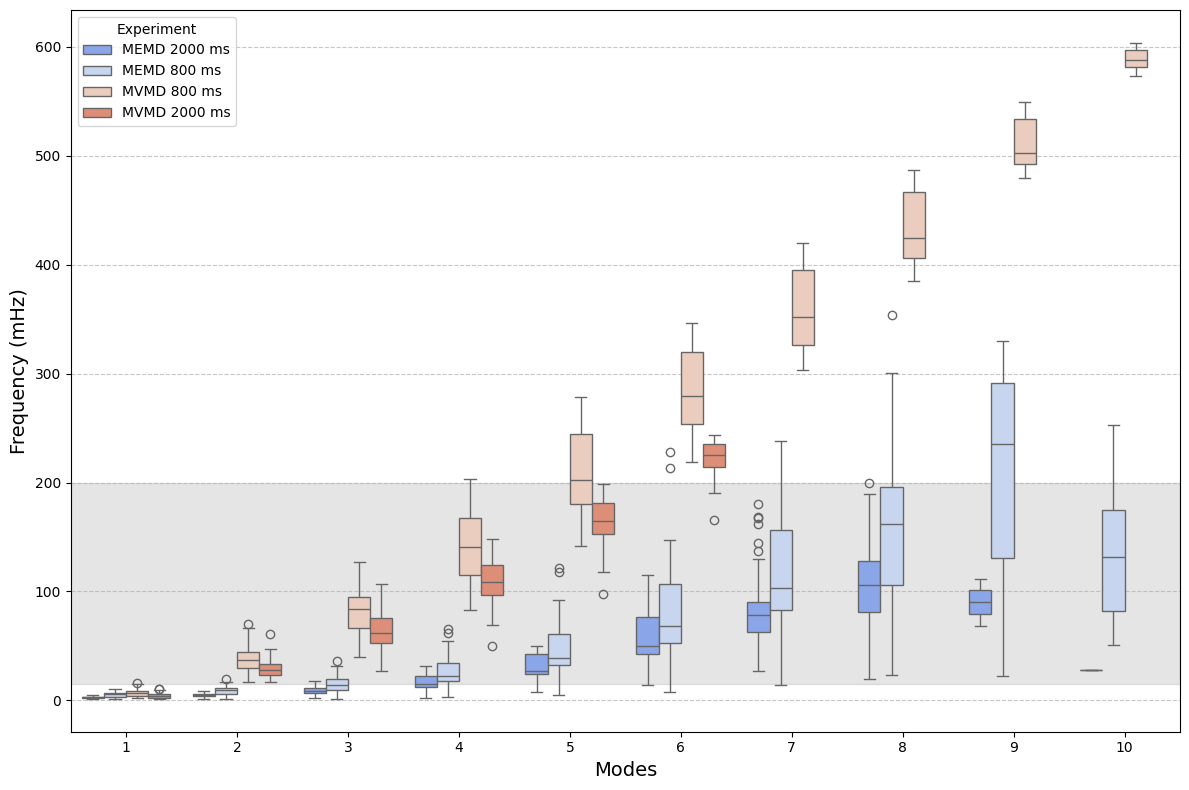

In [209]:
display_frequency_MEMD(combined, disp = True)

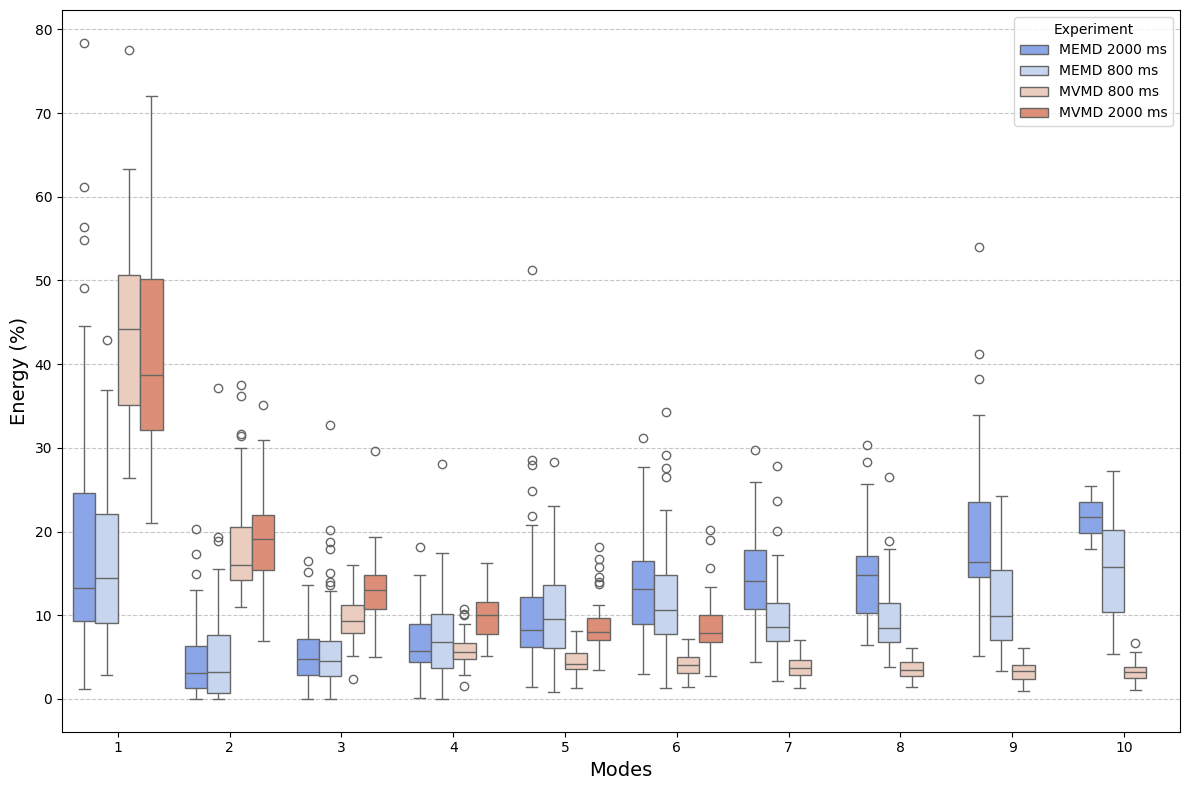

In [210]:
display_energy_MEMD(combined, disp = True)

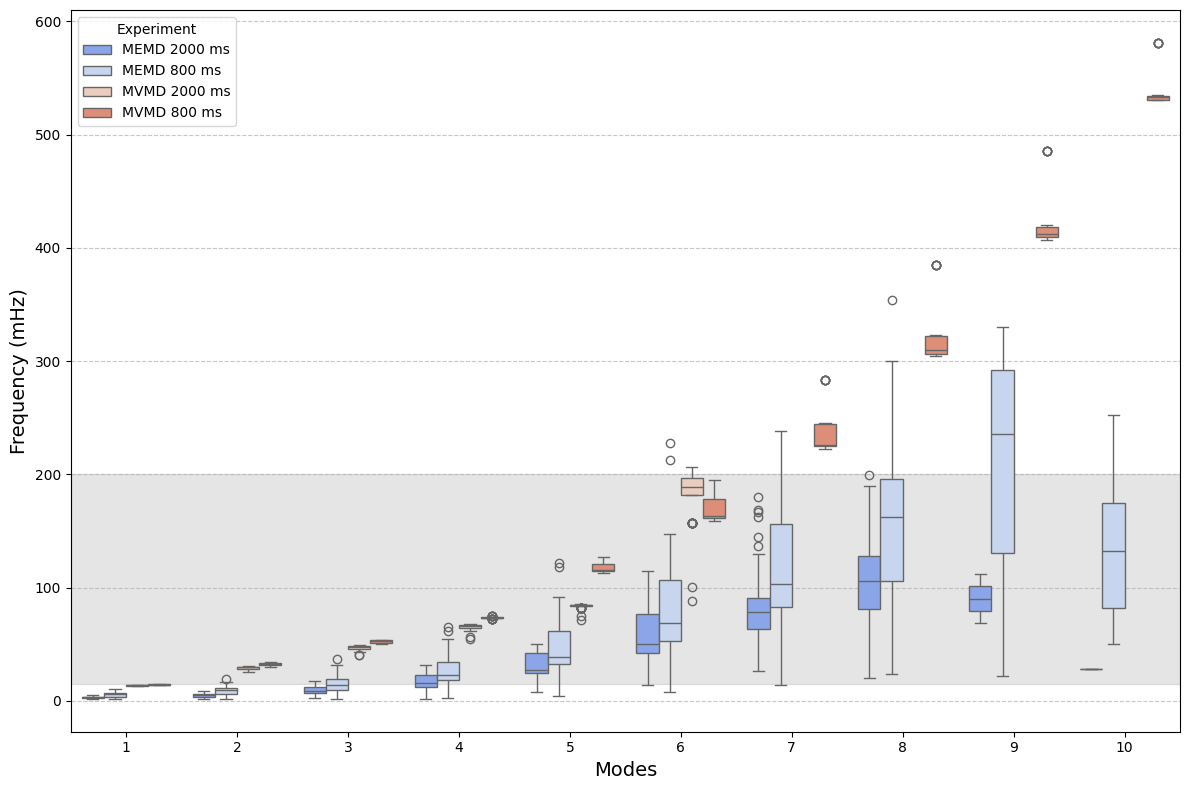

## Frequency and energy bandwidth

In [3]:
def freq_study(data_df ,data_dir=None, out_file_name=None):
    long_data = []
    for _, row in tqdm(data_df.iterrows()):
    
        subject = row['subject']
        u_data = row['u']
        sample_rate = row['sample_rate']
        total_modes = len(u_data)
        
        for mode in range(total_modes):
            # Determine frequency and enegry
        
            # Find average banwidth 
            dom_band = np.zeros(2)
            dom_freq = 0.
            n_rois = len(u_data[mode])
            for roi in range(n_rois):
                aux_f, aux_b = find_dominant_frequency(signal=np.squeeze(u_data[mode][roi]),
                                                        fs=1./sample_rate, bandwidth=True)
                dom_freq += aux_f
                dom_band += aux_b

            dom_freq = dom_freq / n_rois
            dom_band = dom_band / n_rois

            long_data.append({'subject': subject,
                                        'Mode': mode,                                            
                                        'Num. modes': total_modes,
                                        'Dom. Frequency': dom_freq*1000,
                                        'Bandw. L': dom_band[0]*1000,
                                        'Bandw. R': dom_band[1]*1000,
                                        'Sample rate': sample_rate})
            
    return pd.DataFrame(long_data)

In [212]:
def find_dominant_frequency(signal, fs=1, bandwidth=False):
    """
    Find the dominant frequency of a temporal signal and the peak bandwidth
    
    Parameters:
        signal (array_like): The input temporal signal.
        sampling frequency or sampling rate(float): The sampling rate of the signal.
    
    Returns:
        dominant_frequency (float): The dominant frequency of the signal.
    """
    from scipy.signal import periodogram, find_peaks, peak_widths, get_window

    freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))

    # Smooth spectorgarm
    u_spectrum = convolve_with_gaussian(signal=u_spectrum, sigma=3)

    u_spectrum /= np.max(u_spectrum)

    # Extend expectrum to avoid problems at zero
    u_spectrum = np.insert(u_spectrum, 0, min(u_spectrum))
    ferq_hz = np.insert(freq_hz, 0, -freq_hz[1])

    # Determine the dominant ferquency peak
    peak_list, _ = find_peaks(u_spectrum, prominence=1)

    
    # Check for unclearsolutions
    if len(peak_list) == 0: # No peak found
        peak_list, _ = find_peaks(u_spectrum, prominence=0.5)

        # If no clear peak is found take the central frequency
        if len(peak_list) == 0:
            peak_list = [1]


    # Determine bandwidth
    if bandwidth:
        results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)

        # Bandwidth
        bandlimit_l = max(0, freq_hz[int(results_half[2][0])])
        bandlimit_r = freq_hz[int(results_half[3][0])]

        # Return the first dominant peak and its bandwidth
        return freq_hz[peak_list][0], [bandlimit_l, bandlimit_r]
    
    else: # Return the first dominant peak
        return freq_hz[peak_list][0]

def convolve_with_gaussian(signal, sigma=1):
    import numpy as np
    from scipy.signal import convolve
    from scipy.signal.windows import gaussian
    
    # Create a Gaussian filter
    gauss_filter = gaussian(int(5 * sigma), sigma)

    # Perform convolution
    convolved_signal = convolve(signal, gauss_filter, mode='same')

    return convolved_signal

In [213]:
res_mvmd2 = freq_study(mvmd_data)

0it [00:00, ?it/s]/tmp/ipykernel_4190/470195233.py:42: PeakPropertyWarning: some peaks have a prominence of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
/tmp/ipykernel_4190/470195233.py:42: PeakPropertyWarning: some peaks have a width of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
15it [00:29,  1.55s/it]/tmp/ipykernel_4190/470195233.py:21: RuntimeWarning: invalid value encountered in divide
  u_spectrum /= np.max(u_spectrum)
130it [02:40,  1.24s/it]


In [214]:
res_memd = freq_study(memd_data)

0it [00:00, ?it/s]/tmp/ipykernel_4190/470195233.py:42: PeakPropertyWarning: some peaks have a prominence of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
/tmp/ipykernel_4190/470195233.py:42: PeakPropertyWarning: some peaks have a width of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
3it [00:03,  1.29s/it]/tmp/ipykernel_4190/470195233.py:21: RuntimeWarning: invalid value encountered in divide
  u_spectrum /= np.max(u_spectrum)
131it [01:58,  1.10it/s]


In [ ]:
res_memd = freq_study(memd_data)
res_memd['Bandwidth'] = res_memd.apply(
    lambda x: (x['Bandw. R'] - x['Bandw. L']), axis=1
)

0it [00:00, ?it/s]/tmp/ipykernel_68354/470195233.py:42: PeakPropertyWarning: some peaks have a prominence of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
/tmp/ipykernel_68354/470195233.py:42: PeakPropertyWarning: some peaks have a width of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
3it [00:04,  1.62s/it]/tmp/ipykernel_68354/470195233.py:21: RuntimeWarning: invalid value encountered in divide
  u_spectrum /= np.max(u_spectrum)
131it [03:02,  1.39s/it]


In [221]:
res_mvmd2['Bandwidth'] = res_mvmd2.apply(
    lambda x: (x['Bandw. R'] - x['Bandw. L']), axis=1
)

In [222]:
grouped_memd = res_mvmd2[res_mvmd2['Sample rate'] == 0.8].groupby('Mode')[['Dom. Frequency', 'Bandwidth']].mean().reset_index()

grouped_memd[['Mode', 'Dom. Frequency', 'Bandwidth']]

,Mode,Dom. Frequency,Bandwidth
0,0,10.087817,19.918748
1,1,40.663025,28.223593
2,2,86.502799,31.774921
3,3,144.113654,34.758596
4,4,213.168351,36.304870
5,5,286.623315,36.934205
6,6,360.745021,37.168054
7,7,436.666791,37.613208
8,8,513.690547,37.991107
9,9,500.490611,25.825035


In [223]:
grouped_memd = res_mvmd2[res_mvmd2['Sample rate'] == 2].groupby('Mode')[['Dom. Frequency', 'Bandwidth']].mean().reset_index()

grouped_memd[['Mode', 'Dom. Frequency', 'Bandwidth']]

,Mode,Dom. Frequency,Bandwidth
0,0,6.574074,13.175188
1,1,30.205639,18.794201
2,2,65.765884,20.220805
3,3,110.461666,21.143738
4,4,164.812620,21.786598
5,5,195.343231,16.825710


In [50]:
res_mvmd2

,subject,Mode,Num. modes,Dom. Frequency,Bandw. L,Bandw. R,Sample rate,Bandwidth
0,sub-53888,0,6,1.666667,0.000000,6.666667,2.0,6.666667
1,sub-53888,1,6,16.788793,8.577586,23.512931,2.0,14.935345
2,sub-53888,2,6,32.428161,23.692529,39.410920,2.0,15.718391
3,sub-53888,3,6,49.533046,40.387931,56.954023,2.0,16.566092
4,sub-53888,4,6,68.498563,59.425287,76.264368,2.0,16.839080
...,...,...,...,...,...,...,...,...
1009,sub-57193,5,10,115.718391,102.794540,127.090517,0.8,24.295977
1010,sub-57193,6,10,172.550287,157.665230,185.395115,0.8,27.729885
1011,sub-57193,7,10,255.352011,239.188218,269.899425,0.8,30.711207
1012,sub-57193,8,10,369.403736,352.198276,384.583333,0.8,32.385057


In [53]:
grouped_memd = res_mvmd2[res_mvmd2['Sample rate'] == 2].groupby('Mode')[['Dom. Frequency', 'Bandwidth']].mean().reset_index()

grouped_memd[['Mode', 'Dom. Frequency', 'Bandwidth']]

,Mode,Dom. Frequency,Bandwidth
0,0,1.666667,6.662007
1,1,18.070927,15.384339
2,2,35.270562,15.962255
3,3,54.055316,16.342905
4,4,73.746699,16.514154
5,5,94.909327,17.158959


In [29]:
mvmd_data = f.experiment_to_df('Run0605/Results_0mean', 'K_6', 'K_10')
res_mvmd = freq_study(mvmd_data)

0it [00:00, ?it/s]/tmp/ipykernel_51499/380191214.py:40: PeakPropertyWarning: some peaks have a prominence of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
/tmp/ipykernel_51499/380191214.py:40: PeakPropertyWarning: some peaks have a width of 0
  results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)
131it [01:12,  1.80it/s]


In [ ]:
grouped_memd = res_mvmd2[res_mvmd2['Sample rate'] == 0.8].groupby('Mode')[['Dom. Frequency', 'Bandw. L', 'Bandw. R']].mean().reset_index()


grouped_memd[['Mode', 'Dom. Frequency', 'Bandwidth']]

,Mode,Dom. Frequency,Bandwidth
0,0,16.907895,22.045523
1,1,35.139771,22.418330
2,2,55.172414,23.008167
3,3,75.940336,23.150711
4,4,119.450368,31.305959
5,5,170.337644,33.697948
6,6,235.811782,35.809891
7,7,319.208006,38.107733
8,8,420.764897,39.687185
9,9,536.153080,39.368698


In [31]:
grouped_memd = res_mvmd[res_mvmd['Sample rate'] == 2].groupby('Mode')[['Dom. Frequency', 'Bandw. L', 'Bandw. R']].mean().reset_index()

grouped_memd['Bandwidth'] = grouped_memd.apply(
    lambda x: (x['Bandw. R'] - x['Bandw. L']), axis=1
)
grouped_memd[['Mode', 'Dom. Frequency', 'Bandwidth']]

,Mode,Dom. Frequency,Bandwidth
0,0,1.682685,0.016018
1,1,1.677540,0.005922
2,2,1.669676,0.000777
3,3,1.666667,0.000000
4,4,1.666667,0.000000
5,5,1.666667,0.000000


# Individual reliability for sFC analysis
In this part we study the reliabiltiy of the individual patterns among individuals. To this aim, we compute the correlation among correlations patterns among all the pairs of individuals.

After the study, the script stores the results in a .csv file

### Reliability analysis MEMD

In [43]:
def reliability_analysis(data_df, experiment_list, n_modes=None, out_file_name = None, zFisher_transform=False):
    """
    Perform reliability analysis among different experiments and store the results in a dataframe.

    Args:
    - experiment_details (list): List of dictionaries containing experiment details.
    - data_dir (str): Directory containing data.
    - out_file_name (str): Name of the output file to store results.
    - zFisher_transform (bool): Flag indicating whether to perform zFisher transformation.

    Returns:
    - pd.DataFrame: DataFrame containing reliability analysis results.
    """
    # Initialize list with all the group results
    res_reliability_list = []
    for (r, sr) in experiment_list:

        u_data = f.get_u_data(data_df, run=r, sample_rate=sr)
        print(f" > Loading data for run {r} and sr {sr}...")
        # Load data)
        
        # u dim > [sub, mode, ROI, time]
        n_participants = len(u_data)
        if not n_modes:
            n_modes = len(u_data[0])
        # Correlation among modes
        for k in range(n_modes):
            # Determian correlation matrices among particiapnts
            corr_matrices = f.correlation_matrices(u_data=u_data, mode=k, 
                                                    participant_list=range(n_participants),
                                                    zFisher=zFisher_transform)
            # Comparison among participants
            flat_mat_list = []
            for participant in range(n_participants):
                indv_mat = np.array(corr_matrices[participant])
                flat_mat_list.append(indv_mat[np.triu_indices(n=len(indv_mat), k=1)])

            # Take the correlation among participants
            for p_i in range(n_participants):
                for p_j in range(p_i + 1, n_participants):
                    # Estimate correlation of the flat part
                    corr_val = np.corrcoef(flat_mat_list[p_i], flat_mat_list[p_j])[0,1]

                    new_res = {'Mode': int(k+1),
                                'Comp.': [np.array([p_i, p_j])],
                                'Total modes':n_modes,
                                'Correlation': corr_val,
                                'zFisher': zFisher_transform,
                                'Experiment' : f'run_{r}_sr_{sr}',}

                    res_reliability_list.append(new_res)
                    
    print(' > Experiment study completed.')
    
    if out_file_name is not None:            
        with open(out_file_name, 'wb') as outp:
            pickle.dump(pd.DataFrame(res_reliability_list), outp, pickle.HIGHEST_PROTOCOL)

        print(">>> Results were stored into a pickle")
                        
    return pd.DataFrame(res_reliability_list)

In [14]:
memd_data['num_timepoints'] = memd_data['num_timepoints'].astype(int)

In [15]:
memd_data1 = memd_data[memd_data['num_timepoints'].isin([300, 375, 750])]

In [16]:
memd_data1

,filepath,num_timepoints,subject,run,sample_rate,u,K,omegas
0,RunMEMD/Results_run-0_2000ms_/sub-53888_300.mat,300,sub-53888,0,2.0,"[[[-0.6846556695073029, -0.6864104057683389, -...",8,"[0.00479885057471264, 0.007643678160919535, 0...."
1,RunMEMD/Results_run-0_2000ms_/sub-55729_300.mat,300,sub-55729,0,2.0,"[[[-1.737080759952938, -1.7335903952901612, -1...",8,"[0.003196839080459769, 0.006458333333333328, 0..."
2,RunMEMD/Results_run-0_2000ms_/sub-55746_300.mat,300,sub-55746,0,2.0,"[[[-1.0779531384873398, -1.0700949464755363, -...",9,"[0.0016666666666666633, 0.004087643678160921, ..."
3,RunMEMD/Results_run-0_2000ms_/sub-55772_300.mat,300,sub-55772,0,2.0,"[[[1.4014405226516655, 1.389679456962186, 1.37...",9,"[0.0021336206896551686, 0.0026293103448275876,..."
4,RunMEMD/Results_run-0_2000ms_/sub-55965_300.mat,300,sub-55965,0,2.0,"[[[-0.07400628491443983, -0.07714172699594468,...",9,"[0.0027945402298850566, 0.0025215517241379323,..."
...,...,...,...,...,...,...,...,...
126,RunMEMD/Results_run-4_800ms_/sub-57132_375.mat,375,sub-57132,4,0.8,"[[[14.174499163590166, 14.104664631379109, 14....",9,"[0.008864942528735629, 0.013390804597701122, 0..."
127,RunMEMD/Results_run-4_800ms_/sub-57140_750.mat,750,sub-57140,4,0.8,"[[[5.25977100908384, 5.251376186518627, 5.2428...",14,"[0.0016666666666666633, 0.0016666666666666633,..."
128,RunMEMD/Results_run-4_800ms_/sub-57142_750.mat,750,sub-57142,4,0.8,"[[[-4.37655417289742, -4.371890376088763, -4.3...",10,"[0.0032974137931034426, 0.00490660919540229, 0..."
129,RunMEMD/Results_run-4_800ms_/sub-57193_750.mat,750,sub-57193,4,0.8,"[[[-8.896958528356727, -8.888102814051203, -8....",10,"[0.0033836206896551667, 0.0068462643678160766,..."


 > Loading data for run 0 and sr 0.8...
 > Loading data for run 1 and sr 0.8...
 > Loading data for run 2 and sr 0.8...
 > Loading data for run 3 and sr 0.8...
 > Loading data for run 4 and sr 0.8...
 > Experiment study completed.


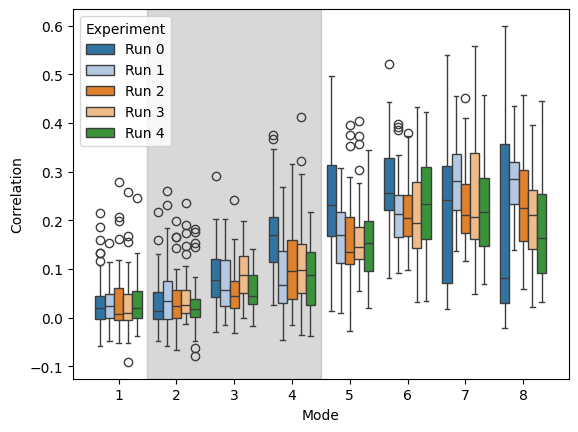

In [17]:
exp_list = [(0, 0.8), (1, 0.8), (2, 0.8), (3, 0.8), (4, 0.8)]
df_reliability_results = reliability_analysis(memd_data1, exp_list, n_modes=8, zFisher_transform=False)
df_reliability_results['Experiment'] = df_reliability_results['Experiment'].apply(lambda x: f"Run {x.split('_')[1]}")
sns.boxplot(x='Mode', y='Correlation', hue='Experiment', palette="tab20", data=df_reliability_results, width = 0.8)
plt.axvspan(1 - 0.5, 4 - 0.5, color='gray', alpha=0.3)  

folder = 'Figures/Run2304/Reliability/'
os.makedirs(folder, exist_ok=True)
plt.savefig(f'{folder}0.8.png', dpi=300, bbox_inches='tight')

 > Loading data for run 0 and sr 2...
 > Loading data for run 1 and sr 2...
 > Loading data for run 2 and sr 2...
 > Loading data for run 3 and sr 2...
 > Loading data for run 4 and sr 2...
 > Experiment study completed.


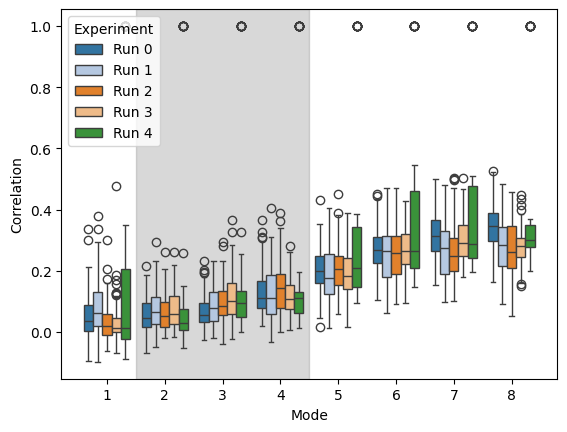

In [63]:
exp_list = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
df_reliability_results = reliability_analysis(memd_data1, exp_list, zFisher_transform=False)
df_reliability_results['Experiment'] = df_reliability_results['Experiment'].apply(lambda x: f"Run {x.split('_')[1]}")
sns.boxplot(x='Mode', y='Correlation', hue='Experiment', palette="tab20", data=df_reliability_results, width = 0.8)
plt.axvspan(1 - 0.5, 4 - 0.5, color='gray', alpha=0.3)  # Adjust the alpha for transparency

folder = 'Figures/Run2304/Reliability/'
os.makedirs(folder, exist_ok=True)
plt.savefig(f'{folder}2.png', dpi=300, bbox_inches='tight')

 > Loading data for run 0 and sr 2...
 > Loading data for run 1 and sr 2...
 > Loading data for run 2 and sr 2...
 > Loading data for run 3 and sr 2...
 > Loading data for run 4 and sr 2...
 > Experiment study completed.


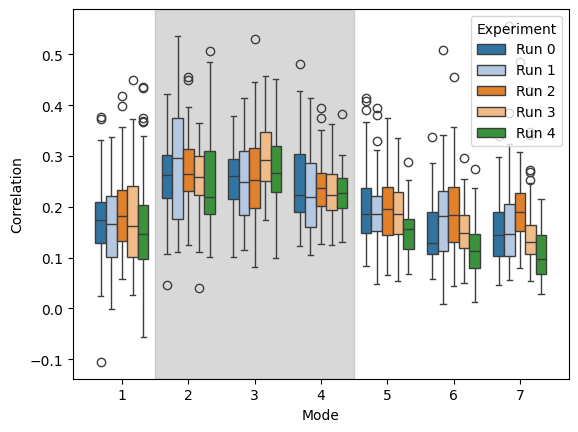

In [ ]:
exp_list = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
df_reliability_results = reliability_analysis(data_df, exp_list, zFisher_transform=False)
df_reliability_results['Experiment'] = df_reliability_results['Experiment'].apply(lambda x: f"Run {x.split('_')[1]}")
sns.boxplot(x='Mode', y='Correlation', hue='Experiment', palette="tab20", data=df_reliability_results, width = 0.8)
plt.axvspan(1 - 0.5, 4 - 0.5, color='gray', alpha=0.3)  # Adjust the alpha for transparency
plt.savefig('Figures/Run1903/Reliability/2.png', dpi=300, bbox_inches='tight')

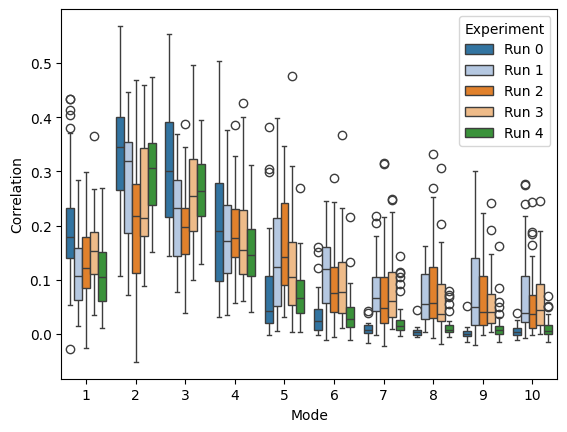

In [ ]:
sns.boxplot(x='Mode', y='Correlation', hue='Experiment', palette="tab20", data=df_reliability_results, width = 0.8, )
plt.savefig('Figures/Run1903/Reliability/Reliability 0.8.png', dpi=300, bbox_inches='tight')

<Axes: xlabel='Mode', ylabel='Correlation'>

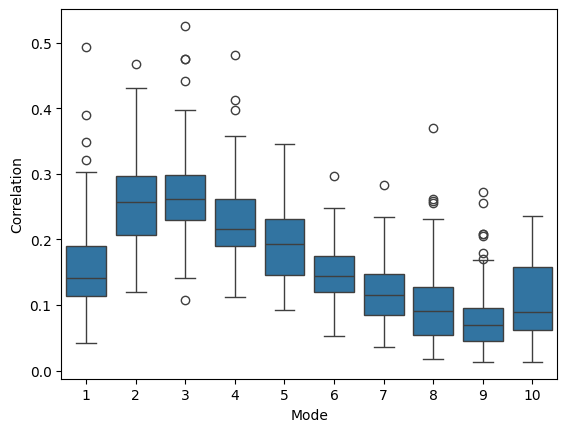

In [ ]:
sns.boxplot(x='Mode', y='Correlation', data=df_reliability_res)

# Sidenote: MVMD central frequencies

In [42]:
def find_dominant_frequency(signal, fs=1, bandwidth=False):
    """
    Find the dominant frequency of a temporal signal and the peak bandwidth
    
    Parameters:
        signal (array_like): The input temporal signal.
        sampling frequency or sampling rate(float): The sampling rate of the signal.
    
    Returns:
        dominant_frequency (floa
        t): The dominant frequency of the signal.
    """
    from scipy.signal import periodogram, find_peaks, peak_widths, get_window

    freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))

    # Smooth spectorgarm
    u_spectrum = convolve_with_gaussian(signal=u_spectrum, sigma=3)
    u_spectrum /= np.max(u_spectrum)

    # Extend expectrum to avoid problems at zero
    u_spectrum = np.insert(u_spectrum, 0, min(u_spectrum))
    ferq_hz = np.insert(freq_hz, 0, -freq_hz[1])

    # Determine the dominant ferquency peak
    peak_list, _ = find_peaks(u_spectrum, prominence=1)

    
    # Check for unclearsolutions
    if len(peak_list) == 0: # No peak found
        peak_list, _ = find_peaks(u_spectrum, prominence=0.5)

        # If no clear peak is found take the central frequency
        if len(peak_list) == 0:
            peak_list = [1]


    # Determine bandwidth
    if bandwidth:
        results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)

        # Bandwidth
        bandlimit_l = max(0, freq_hz[int(results_half[2][0])])
        bandlimit_r = freq_hz[int(results_half[3][0])]

        # Return the first dominant peak and its bandwidth
        return freq_hz[peak_list][0], [bandlimit_l, bandlimit_r]
    
    else: # Return the first dominant peak
        return freq_hz[peak_list][0]

def convolve_with_gaussian(signal, sigma=1):
    import numpy as np
    from scipy.signal import convolve
    from scipy.signal.windows import gaussian
    
    # Create a Gaussian filter
    gauss_filter = gaussian(int(5 * sigma), sigma)

    # Perform convolution
    convolved_signal = convolve(signal, gauss_filter, mode='same')

    return convolved_signal

In [6]:
denoised = pickle.load(open('DATA/denoised.pkl', 'rb'))
preproc = pickle.load(open('DATA/preproc.pkl', 'rb'))

In [6]:
from scipy.signal import butter, filtfilt

def band_pass_filter(signal, lowcut, highcut, fs, order=4):
    """
    Apply a band-pass filter to a signal.

    Parameters:
        signal (array-like): The input signal.
        lowcut (float): The lower cutoff frequency (Hz).
        highcut (float): The upper cutoff frequency (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


## Bandpassed

In [7]:
denoised_ind

subject                                                   sub-55162
run                                                               1
sample_rate                                                     0.8
num_timepoints                                                  375
u                 [[[-0.422550801595051, -0.34261763509114473, -...
K                                                                 1
u_hat                                                          None
omegas                                                         None
Name: 6, dtype: object

In [7]:
#mean
def freq_and_spec(signal, fs):
    freq, u_spectrum = (periodogram(signal, fs=fs, scaling='spectrum', detrend=False, window=get_window('hamming', Nx=len(signal))))
    #return freq, convolve_with_gaussian(signal=u_spectrum, sigma=3)
    return freq, u_spectrum
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
randind = np.random.randint(0, 232)

ind = np.random.randint(0, len(denoised))
denoised_ind = denoised.iloc[ind]

run = denoised_ind.run
num_timepoints = denoised_ind.num_timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate

preproc_ind = preproc[(preproc['run'] == run) & (preproc['subject'] == subject) & (preproc['num_timepoints'] == num_timepoints)].iloc[0]

mvmd_data = loadmat(f'Run0605/Results_org/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat')['u']

ds = []
ps = []
for i in range(len(denoised_ind.u[0])):
    signal = denoised_ind.u[0][i]
    # Apply band-pass filter
    filtered_signal = band_pass_filter(signal, lowcut=0.008, highcut=0.01, fs=1/sr)
    _, u_spectrum = freq_and_spec(filtered_signal, fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ds.append(u_spectrum)
    _, u_spectrum = freq_and_spec(preproc_ind.u[0][i], fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ps.append(u_spectrum)

ds = np.mean(ds, axis=0)
ps = np.mean(ps, axis=0)

inds = [1,2]
m_sum = np.sum(mvmd_data[inds,randind], axis=0)

fs = 1/sr



freq_hz3, u_spectrum3 = freq_and_spec(m_sum, fs)

u_spectrum3 = u_spectrum3/np.max(u_spectrum3)

print(ds.shape, ps.shape, u_spectrum3.shape)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

fig.suptitle(f'Sample Rate {sr}', fontsize=16)
# First subplot
axes[0].plot(freq_hz3, ps)
axes[0].plot(freq_hz3, ds)
axes[0].plot(freq_hz3, u_spectrum3)

axes[0].legend(['Preproc', 'Denoised', 'Sum of selected modes'])
axes[0].set_xlabel("Frequency (mHz)")
axes[0].set_ylabel("Amplitude")
axes[0].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[0].grid()

# Second subplot
for mode_idx in range(mvmd_data.shape[0]):
    freq_hz, u_spectrum = freq_and_spec(mvmd_data[mode_idx, randind], fs)
    #u_spectrum = u_spectrum / np.max(u_spectrum)  # Normalize
    axes[1].plot(freq_hz, u_spectrum, label=f'Mode {mode_idx + 1}')

axes[1].legend()
axes[1].set_xlabel("Frequency (mHz)")
axes[1].set_ylabel("Amplitude")
axes[1].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[1].grid()

plt.tight_layout()
plt.show()

NameError: name 'band_pass_filter' is not defined

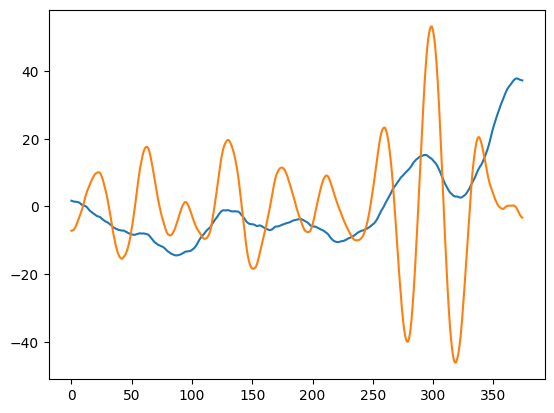

In [223]:

run = denoised_ind.run
num_timepoints = denoised_ind.num_timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate

mvmd_data = loadmat(f'Run1903/Results_0mean/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat')['u']

plt.plot(mvmd_data[0][1])
plt.plot(mvmd_data[1][1])

In [356]:

run = denoised_ind.run
num_timepoints = denoised_ind.num_timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate

randind = np.random.randint(0, 232)

ind = np.random.randint(0, len(denoised))
denoised_ind = denoised.iloc[ind]

run = 0
num_timepoints = denoised_ind.num_timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate



58.34175788739779


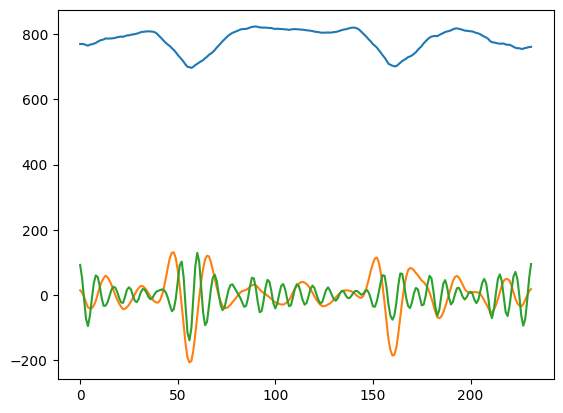

In [358]:
f1 = f'Run1403/Results_org/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat'
omega = loadmat(f1)['omega']
print(omega[-1][2]*1000)

u = loadmat(f1)['u']

plt.plot(u[0][1])
plt.plot(u[1][1])
plt.plot(u[2][1])

12.374583825537393


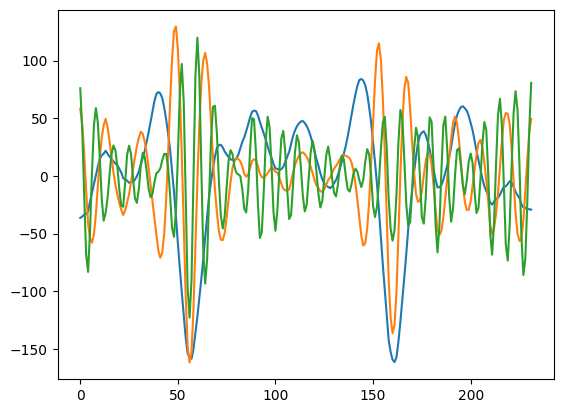

In [360]:
f1 = f'Run1403/Results_0mean/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat'
omega = loadmat(f1)['omega']
print(omega[-1][0]*1000)

u = loadmat(f1)['u']

plt.plot(u[0][1])
plt.plot(u[1][1])
plt.plot(u[2][1])

7.290756997380566


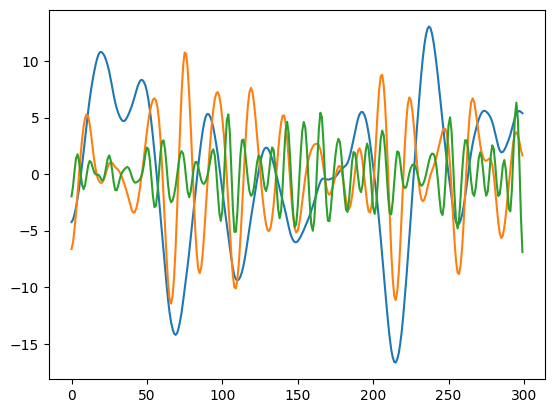

In [362]:
f1 = f'Run2904/Results_detrended/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat'
omega = loadmat(f1)['omega']
print(omega[-1][0]*1000)

u = loadmat(f1)['u']

plt.plot(u[0][1])
plt.plot(u[1][1])
plt.plot(u[2][1])

88.65243464804949


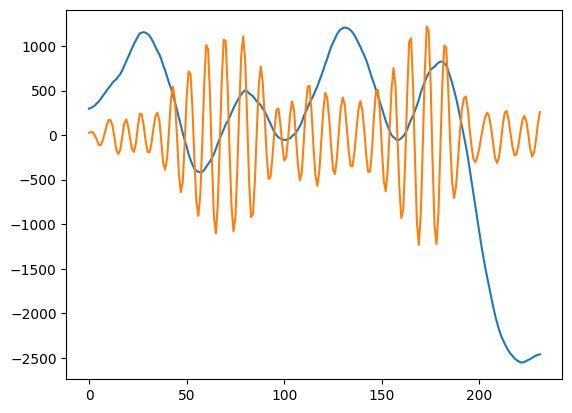

In [352]:
f1 = f'Run1403/Results_0meanTotal/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat'
omega = loadmat(f1)['omega']
print(omega[-1][2]*1000)

u = loadmat(f1)['u']

plt.plot(u[0][1])
plt.plot(u[3][1])

## Mean

In [303]:
denoised = pickle.load(open('DATA/denoised.pkl', 'rb'))
preproc = pickle.load(open('DATA/preproc.pkl', 'rb'))

(151,) (151,) (151,)


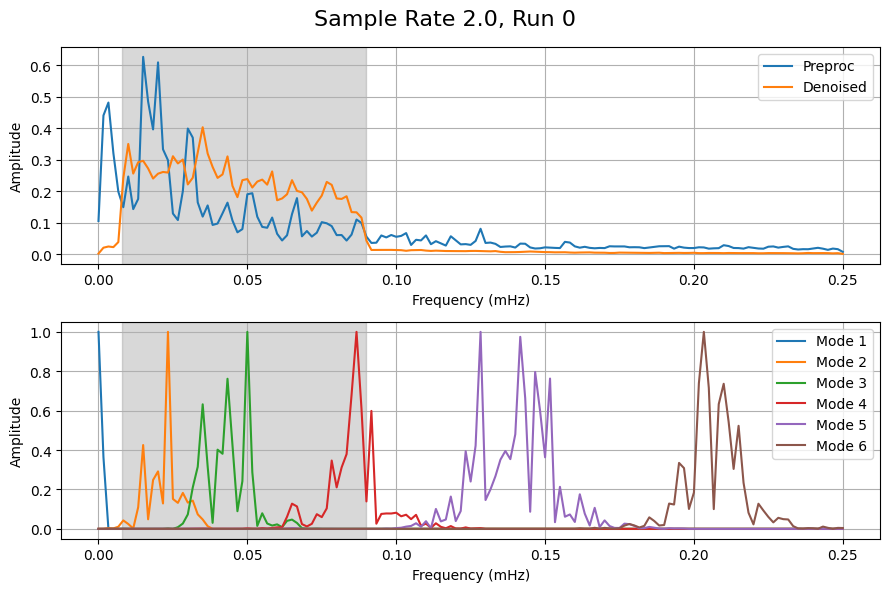

In [ ]:
#mean
def freq_and_spec(signal, fs):
    freq, u_spectrum = (periodogram(signal, fs=fs, scaling='spectrum', detrend=None, window=get_window('hamming', Nx=len(signal))))
    #return freq, convolve_with_gaussian(signal=u_spectrum, sigma=3)
    return freq, u_spectrum
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
randind = np.random.randint(0, 232)

ind = np.random.randint(0, len(denoised))
denoised_ind = denoised.iloc[ind]

run = denoised_ind.run
num_timepoints = denoised_ind.num_timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate

preproc_ind = preproc[(preproc['run'] == run) & (preproc['subject'] == subject) & (preproc['num_timepoints'] == num_timepoints)].iloc[0]

mvmd_data = loadmat(f'Run0605/Results_org/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat')['u']

ds = []
ps = []
for i in range(len(denoised_ind.u[0])):
    _, u_spectrum = freq_and_spec(denoised_ind.u[0][i], fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ds.append(u_spectrum)
    _, u_spectrum = freq_and_spec(preproc_ind.u[0][i], fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ps.append(u_spectrum)

ds = np.mean(ds, axis=0)
ps = np.mean(ps, axis=0)

inds = [0,1,2,3,4,5]
m_sum = np.sum(mvmd_data[inds,randind], axis=0)

fs = 1/sr

freq_hz3, u_spectrum3 = freq_and_spec(m_sum, fs)

u_spectrum3 = u_spectrum3/np.max(u_spectrum3)

print(ds.shape, ps.shape, u_spectrum3.shape)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

fig.suptitle(f'Sample Rate {sr}, Run {run}', fontsize=16)
# First subplot
#axes[0].plot(freq_hz3, ps)
axes[0].plot(freq_hz3, ps)
axes[0].plot(freq_hz3, ds)

axes[0].legend(['Preproc', 'Denoised', 'Sum of selected modes'])
axes[0].set_xlabel("Frequency (mHz)")
axes[0].set_ylabel("Amplitude")
axes[0].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[0].grid()

# Second subplot
for mode_idx in range(mvmd_data.shape[0]):
    freq_hz, u_spectrum = freq_and_spec(mvmd_data[mode_idx, randind], fs)
    u_spectrum = u_spectrum / np.max(u_spectrum)  # Normalize
    axes[1].plot(freq_hz, u_spectrum, label=f'Mode {mode_idx + 1}')

axes[1].legend()
axes[1].set_xlabel("Frequency (mHz)")
axes[1].set_ylabel("Amplitude")
axes[1].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[1].grid()

plt.tight_layout()
plt.show()

## Average mode 

In [ ]:
mvmd_df1903 = f.experiment_to_df('Run1903/Results_0mean', 'K_6', 'K_10')
mvmd_df_2_0mean = f.experiment_to_df('Run0605/Results_0mean', 'K_6', 'K_10')
mvmd_df_denoised = f.experiment_to_df('Run0605/Results_denoised', 'K_6', 'K_10')
mvmd_df_org = f.experiment_to_df('Run0605/Results_org', 'K_6', 'K_10')

In [ ]:
def multi_run_analysis(data_df, normalize = False):
    def freq_and_spec(signal, fs):
        freq, u_spectrum = (periodogram(signal, fs=fs, scaling='spectrum', detrend=None, window=get_window('hamming', Nx=len(signal))))
        #return freq, convolve_with_gaussian(signal=u_spectrum, sigma=3)
        return freq, u_spectrum
    from scipy.signal import periodogram, find_peaks, peak_widths, get_window
    run_spectra = []
    for run in tqdm(range(5)):
        mvmd_run0 = data_df[data_df['run'] == run]

        spectra = []

        for _, row in tqdm(mvmd_run0.iterrows()):
            subject = row['subject']
            u_data = row['u']
            
            # Calculate the spectrum for each mode
            mode_spectra = []
            for mode_idx in range(u_data.shape[0]):
                mode_s = []
                for roi_idx in range(u_data.shape[1]):
                    # Calculate the spectrum for each ROI
                    freq_hz, u_spectrum = freq_and_spec(u_data[mode_idx, roi_idx], fs=1/row['sample_rate'])
                    if normalize:
                        # Normalize the spectrum
                        u_spectrum = u_spectrum if np.max(u_spectrum) == 0 else u_spectrum/ np.max(u_spectrum)
                    mode_s.append(u_spectrum)
                mode_spectra.append(np.mean(mode_s, axis=0))
            mode_spectra = np.array(mode_spectra)
            # Calculate the mean spectrum across all modes
            spectra.append(mode_spectra)
        run_spectra.append(spectra)
    return run_spectra, freq_hz

def plot_mean_spectrum(spectra_, freq_hz, output = None):
    plt.figure(figsize=(5, 15))  # Adjust the figure size to accommodate all subplots
    for run_idx, spectra in enumerate(spectra_):
        mean_spectrum = np.mean(spectra, axis=0)  # Calculate mean spectrum for the current run
        

        plt.subplot(len(spectra_), 1, run_idx + 1)  # Create a subplot for each run
        for mode_idx in range(mean_spectrum.shape[0]):
            plt.plot(freq_hz*1000, mean_spectrum[mode_idx], label=f'Mode {mode_idx + 1}')
        if run_idx == 0:
            plt.legend()
        plt.ylabel(f"Run {run_idx + 1}", fontsize=10)

        plt.axvspan(8, 200, color='gray', alpha=0.2)
        plt.axvspan(8, 90, color='blue', alpha=0.1)  # Add a shaded rectangle
        plt.grid()
    plt.xlabel("Frequency (mHz)")
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
run_spectra_all, freq_hz = multi_run_analysis(mvmd_df_all[mvmd_df_all['sample_rate'] == 2], normalize=False)
run_spectra_all, freq_hz = multi_run_analysis(mvmd_df_all[mvmd_df_all['sample_rate'] == 2], normalize=False)
run_spectra_all, freq_hz = multi_run_analysis(mvmd_df_all[mvmd_df_all['sample_rate'] == 2], normalize=False)

15it [00:02,  5.80it/s]0:00<?, ?it/s]
15it [00:02,  6.11it/s]0:02<00:10,  2.59s/it]
14it [00:02,  6.31it/s]0:05<00:07,  2.51s/it]
14it [00:02,  5.93it/s]0:07<00:04,  2.38s/it]
13it [00:02,  5.90it/s]0:09<00:02,  2.37s/it]
100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


In [37]:
mvmd_df_all = f.experiment_to_df('Run0905/Results_0mean', 'K_6', 'K_10')
mvmd_df_between = f.experiment_to_df('Run0605/Results_0mean', 'K_6', 'K_10')
mvmd_df_signle = f.experiment_to_df('Run1005/Results_0mean', 'K_6', 'K_10')

In [40]:
run_spectra_all, freq_hz = multi_run_analysis(mvmd_df_all[mvmd_df_all['sample_rate'] == 0.8], normalize=False)
run_spectra_between, freq_hz = multi_run_analysis(mvmd_df_between[mvmd_df_between['sample_rate'] == 0.8], normalize=False)
run_spectra_signle, freq_hz = multi_run_analysis(mvmd_df_signle[mvmd_df_signle['sample_rate'] == 0.8], normalize=False)

13it [00:03,  3.54it/s]0:00<?, ?it/s]
11it [00:03,  3.57it/s]0:03<00:14,  3.68s/it]
12it [00:03,  3.56it/s]0:06<00:09,  3.33s/it]
11it [00:03,  3.46it/s]0:10<00:06,  3.35s/it]
11it [00:03,  3.51it/s]0:13<00:03,  3.28s/it]
100%|██████████| 5/5 [00:16<00:00,  3.29s/it]
13it [00:03,  3.49it/s]0:00<?, ?it/s]
11it [00:03,  3.55it/s]0:03<00:14,  3.73s/it]
12it [00:03,  3.47it/s]0:06<00:10,  3.36s/it]
11it [00:03,  3.52it/s]0:10<00:06,  3.41s/it]
11it [00:03,  3.56it/s]0:13<00:03,  3.30s/it]
100%|██████████| 5/5 [00:16<00:00,  3.31s/it]
13it [00:03,  3.58it/s]0:00<?, ?it/s]
11it [00:03,  3.58it/s]0:03<00:14,  3.64s/it]
12it [00:03,  3.52it/s]0:06<00:09,  3.31s/it]
11it [00:03,  3.55it/s]0:10<00:06,  3.35s/it]
11it [00:03,  3.51it/s]0:13<00:03,  3.25s/it]
100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


In [51]:
run_spectra_all[0][1].shape

(10, 188)

(376,)

In [41]:
plot_mean_spectrum(run_spectra_all, freq_hz, output='Figures/Mode_Spectral_Analysis/ALL_800.png')
plot_mean_spectrum(run_spectra_between, freq_hz, output='Figures/Mode_Spectral_Analysis/between_800.png')
plot_mean_spectrum(run_spectra_signle, freq_hz, output='Figures/Mode_Spectral_Analysis/single_800.png')

#run_spectra_denoised

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (13, 10) + inhomogeneous part.

<Figure size 500x1500 with 0 Axes>

In [39]:
run_spectra_denoised, freq_hz = multi_run_analysis(mvmd_df_denoised[mvmd_df_denoised['sample_rate'] == 2])

15it [00:04,  3.22it/s]0:00<?, ?it/s]
15it [00:03,  3.76it/s]0:04<00:18,  4.67s/it]
14it [00:03,  3.93it/s]0:08<00:12,  4.28s/it]
14it [00:04,  3.32it/s]0:12<00:07,  3.96s/it]
13it [00:03,  3.26it/s]0:16<00:04,  4.06s/it]
100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


In [7]:
run_spectra0605org, freq_hz = multi_run_analysis(mvmd_df_org[mvmd_df_org['sample_rate'] == 2])

15it [00:02,  5.19it/s]0:00<?, ?it/s]
15it [00:02,  5.19it/s]0:02<00:11,  2.90s/it]
14it [00:02,  5.85it/s]0:05<00:08,  2.90s/it]
14it [00:02,  5.74it/s]0:08<00:05,  2.67s/it]
13it [00:02,  5.13it/s]0:10<00:02,  2.58s/it]
100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


In [ ]:
run_spectra0605mean, freq_hz = multi_run_analysis(mvmd_df_2_0mean[mvmd_df_2_0mean['sample_rate'] == 2])

15it [00:03,  4.38it/s]0:00<?, ?it/s]
15it [00:03,  4.23it/s]0:03<00:13,  3.43s/it]
14it [00:02,  4.84it/s]0:06<00:10,  3.50s/it]
14it [00:03,  4.52it/s]0:09<00:06,  3.23s/it]
13it [00:02,  5.10it/s]0:12<00:03,  3.18s/it]
100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


In [168]:
mean_spectrum = np.mean(spectra, axis=0)

In [165]:
mean_spectrum.shape

(6, 151)

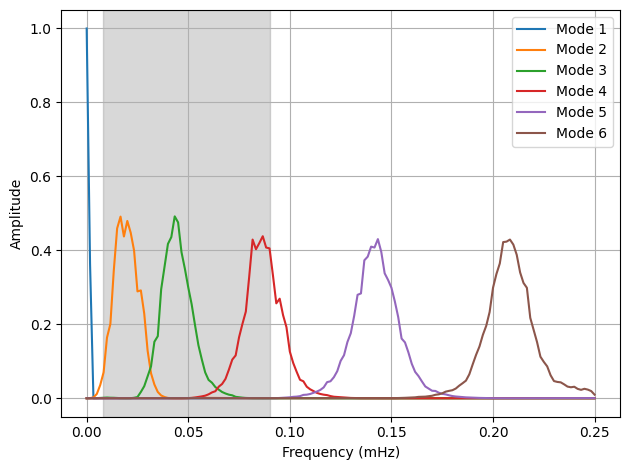

In [ ]:



for subject in subjects:


preproc_ind = preproc[(preproc['run'] == run) & (preproc['subject'] == subject) & (preproc['num_timepoints'] == num_timepoints)].iloc[0]

mvmd_data = loadmat(f'Run0605/Results_org/Results_run-{run}_{int(sr*1000)}ms_/K_{6 if sr == 2 else 10}/{subject}_{num_timepoints}.mat')['u']

ds = []
ps = []
for i in range(len(denoised_ind.u[0])):
    _, u_spectrum = freq_and_spec(denoised_ind.u[0][i], fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ds.append(u_spectrum)
    _, u_spectrum = freq_and_spec(preproc_ind.u[0][i], fs=1/sr)
    u_spectrum = u_spectrum/np.max(u_spectrum)
    ps.append(u_spectrum)

ds = np.mean(ds, axis=0)
ps = np.mean(ps, axis=0)

inds = [0,1,2,3,4,5]
m_sum = np.sum(mvmd_data[inds,randind], axis=0)

fs = 1/sr

freq_hz3, u_spectrum3 = freq_and_spec(m_sum, fs)

u_spectrum3 = u_spectrum3/np.max(u_spectrum3)

print(ds.shape, ps.shape, u_spectrum3.shape)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

fig.suptitle(f'Sample Rate {sr}, Run {run}', fontsize=16)
# First subplot
#axes[0].plot(freq_hz3, ps)
axes[0].plot(freq_hz3, ps)
axes[0].plot(freq_hz3, ds)

axes[0].legend(['Preproc', 'Denoised', 'Sum of selected modes'])
axes[0].set_xlabel("Frequency (mHz)")
axes[0].set_ylabel("Amplitude")
axes[0].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[0].grid()

# Second subplot
for mode_idx in range(mvmd_data.shape[0]):
    freq_hz, u_spectrum = freq_and_spec(mvmd_data[mode_idx, randind], fs)
    u_spectrum = u_spectrum / np.max(u_spectrum)  # Normalize
    axes[1].plot(freq_hz, u_spectrum, label=f'Mode {mode_idx + 1}')

axes[1].legend()
axes[1].set_xlabel("Frequency (mHz)")
axes[1].set_ylabel("Amplitude")
axes[1].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[1].grid()

plt.tight_layout()
plt.show()

array([ 13.25483365,  26.94464874,  43.2748718 ,  61.5935655 ,
        81.88683979, 156.97135952])

(151,) (151,) (151,)


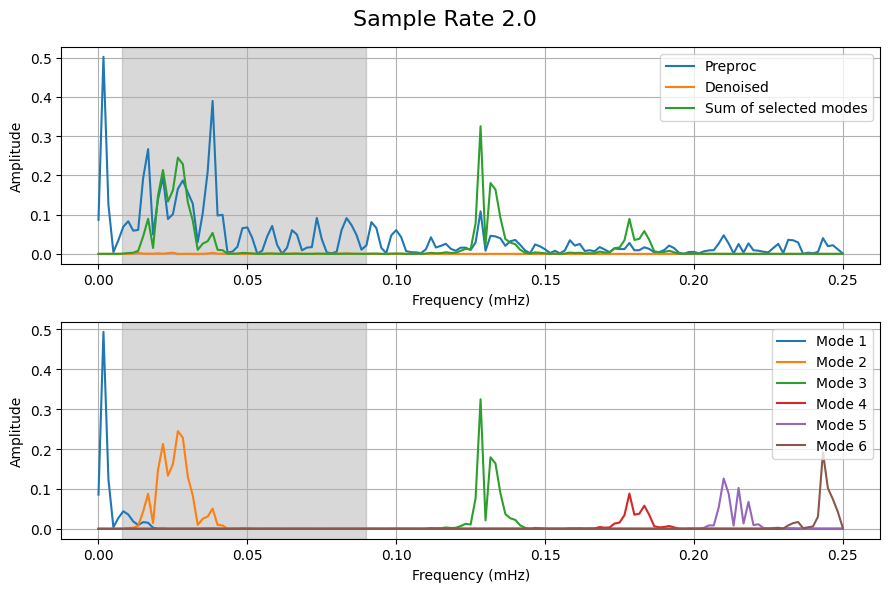

In [ ]:
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
randind = np.random.randint(0, 232)

ind = np.random.randint(0, len(denoised))
denoised_ind = denoised.iloc[ind]
preproc_ind = preproc.iloc[ind]

run = denoised_ind.run
num_timepoints = denoised_ind.timepoints
subject = denoised_ind.subject
sr = denoised_ind.sample_rate

mvmd_data = loadmat(f'Run0605/Results_0mean/Results_run-{run}_{int(sr*1000)}ms_/K_6/{subject}_{num_timepoints}.mat')['u']

ds = denoised_ind.u[0,randind]
ps = preproc_ind.u[0,randind]

inds = [1,2,3]

m_sum = np.sum(mvmd_data[inds,randind], axis=0)

fs = 1/sr

def freq_and_spec(signal, fs):
    freq, u_spectrum = (periodogram(signal, fs=fs, scaling='spectrum', detrend=False, window=get_window('hamming', Nx=len(signal))))
    #return freq, convolve_with_gaussian(signal=u_spectrum, sigma=3)
    return freq, u_spectrum

freq_hz1, u_spectrum1 = freq_and_spec(ps, fs)
freq_hz2, u_spectrum2 = freq_and_spec(ds, fs)
freq_hz3, u_spectrum3 = freq_and_spec(m_sum, fs)

#u_spectrum3 = u_spectrum3/np.max(u_spectrum3)
#u_spectrum1 = u_spectrum1/np.max(u_spectrum1)
#u_spectrum2 = u_spectrum2/np.max(u_spectrum2)

print(u_spectrum1.shape, u_spectrum2.shape, u_spectrum3.shape)

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

fig.suptitle(f'Sample Rate {sr}', fontsize=16)
# First subplot
axes[0].plot(freq_hz1, u_spectrum1)
axes[0].plot(freq_hz1, u_spectrum2)
axes[0].plot(freq_hz1, u_spectrum3)

axes[0].legend(['Preproc', 'Denoised', 'Sum of selected modes'])
axes[0].set_xlabel("Frequency (mHz)")
axes[0].set_ylabel("Amplitude")
axes[0].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[0].grid()

# Second subplot
for mode_idx in range(mvmd_data.shape[0]):
    freq_hz, u_spectrum = freq_and_spec(mvmd_data[mode_idx, randind], fs)
    #u_spectrum = u_spectrum / np.max(u_spectrum)  # Normalize
    axes[1].plot(freq_hz, u_spectrum, label=f'Mode {mode_idx + 1}')

axes[1].legend()
axes[1].set_xlabel("Frequency (mHz)")
axes[1].set_ylabel("Amplitude")
axes[1].axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:


# Example usage
lowcut = 0.008  # Hz
highcut = 0.09  # Hz
fs = 1 / 0.8    # Sampling frequency (Hz)
filtered_signal = band_pass_filter(ps, lowcut, highcut, fs)

(375,)


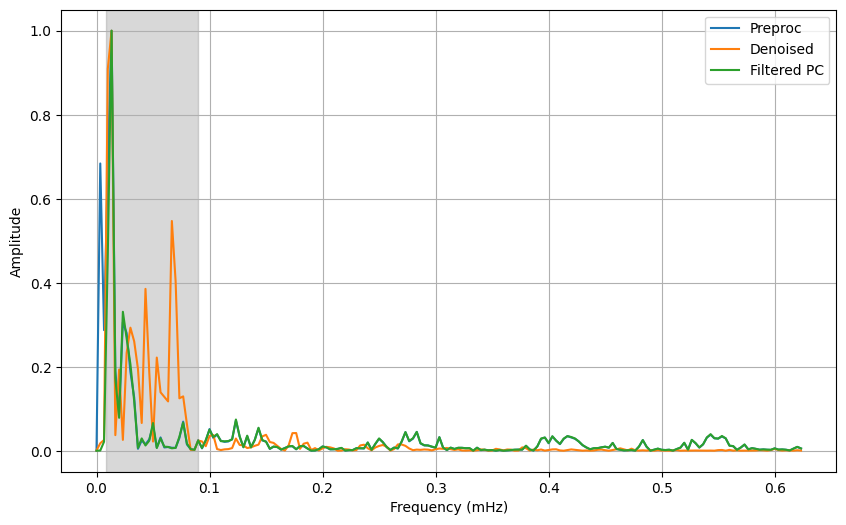

In [53]:
cutoff_frequency = 0.008  # Hz


randind = np.random.randint(0, 232)
ds = denoised.iloc[100].u[0,randind]
ps = preproc.iloc[100].u[0,randind]

fs = 1/0.8

print(ps.shape)

filtered_signal = high_pass_filter(ps, cutoff_frequency, fs=fs)

freq_hz1, u_spectrum1 = periodogram(ps, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(ps)))

freq_hz2, u_spectrum2 = periodogram(ds, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(ds)))

freq_hz3, u_spectrum3 = periodogram(filtered_signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(filtered_signal)))

u_spectrum3 = u_spectrum3/np.max(u_spectrum3)
u_spectrum1 = u_spectrum1/np.max(u_spectrum1)
u_spectrum2 = u_spectrum2/np.max(u_spectrum2)
plt.figure(figsize=(10, 6))
plt.plot(freq_hz1, u_spectrum1)
plt.plot(freq_hz1, u_spectrum2)
plt.plot(freq_hz1, u_spectrum3)

plt.legend(['Preproc', 'Denoised', 'Filtered PC'])
#plt.title(f"Spectrum of Mode {mode + 1}, omega = {mvmd_data.iloc[id].omega[-1,mode] * 1000} mHz")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
#plt.xlim(0, 0.2)
plt.axvspan(0.008, 0.09, color='gray', alpha=0.3)  # Add a shaded rectangle
plt.grid()

plt.show()

In [8]:
signal_0 = mvmd_data.iloc[0].u[0,0]
signal_1 = mvmd_data.iloc[0].u[1,0]

In [17]:
mvmd_data.iloc[2].omegas[0]

0.008244888663254

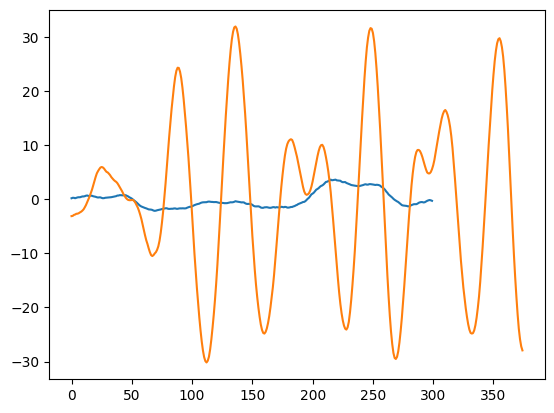

In [48]:
plt.plot(mvmd_data.iloc[2].u[0,0])
plt.plot(signal_1)

In [ ]:
freq, [bandl, bandr]=find_dominant_frequency(mvmd_data.iloc[5].u[0,0], fs=1/2 bandwidth=True)
print(f'frequency : {freq*1000}, bandl : {bandl*1000}, bandr : {bandr*1000}')

frequency : 23.333333333333336, bandl : 6.666666666666667, bandr : 33.333333333333336


In [195]:
mvmd_data.iloc[id]

participant                                               sub-55162
filepath          Run2304/Results_0mean/Results_run-3_800ms_/K_1...
num_timepoints                                                  375
u                 [[[2.6686020476686134, 2.463691679203158, 2.17...
u_hat             [[[(-5.99928758578167e-11+0j), (-10.4443499002...
omega             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
sample_rate                                                     0.8
run                                                               3
Name: 80, dtype: object

In [196]:
denoised_u = loadmat('Run2304/Results_0mean/Results_run-0_2000ms_/alpha_2500/sub-56122_300.mat')['u']
print(find_dominant_frequency(denoised_u[0,0], fs=1/2, bandwidth=True))
print(find_dominant_frequency(mvmd_data.iloc[id].u[0,0], fs=1/2, bandwidth=True))

(0.005, [0, 0.011666666666666667])
(0.008, [0.0013333333333333333, 0.013333333333333332])


In [192]:
om = loadmat('Run2304/Results_0mean/Results_run-0_800ms_/K_12/sub-56017_375.mat')['omega']
om[-1,0]

0.00955195789578838

In [128]:
freq_hz

array([0.        , 0.00166667, 0.00333333, 0.005     , 0.00666667,
       0.00833333, 0.01      , 0.01166667, 0.01333333, 0.015     ,
       0.01666667, 0.01833333, 0.02      , 0.02166667, 0.02333333,
       0.025     , 0.02666667, 0.02833333, 0.03      , 0.03166667,
       0.03333333, 0.035     , 0.03666667, 0.03833333, 0.04      ,
       0.04166667, 0.04333333, 0.045     , 0.04666667, 0.04833333,
       0.05      , 0.05166667, 0.05333333, 0.055     , 0.05666667,
       0.05833333, 0.06      , 0.06166667, 0.06333333, 0.065     ,
       0.06666667, 0.06833333, 0.07      , 0.07166667, 0.07333333,
       0.075     , 0.07666667, 0.07833333, 0.08      , 0.08166667,
       0.08333333, 0.085     , 0.08666667, 0.08833333, 0.09      ,
       0.09166667, 0.09333333, 0.095     , 0.09666667, 0.09833333,
       0.1       , 0.10166667, 0.10333333, 0.105     , 0.10666667,
       0.10833333, 0.11      , 0.11166667, 0.11333333, 0.115     ,
       0.11666667, 0.11833333, 0.12      , 0.12166667, 0.12333

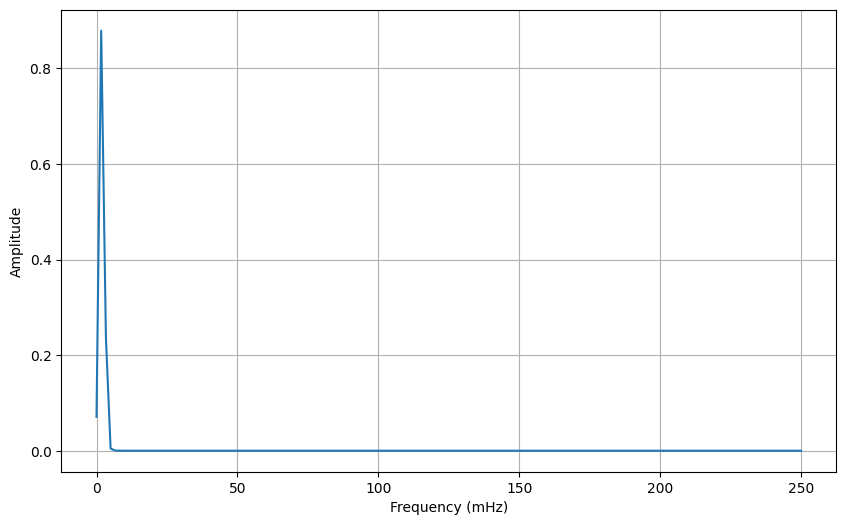

In [154]:
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
denoised_u = loadmat('Run2304/Results_0mean/Results_run-0_2000ms_/alpha_5000/sub-55746_300.mat')['u']
fs = 1/2
denoised_u = loadmat('Run2304/Results_0mean/Results_run-0_2000ms_/alpha_2000/sub-55746_300.mat')['u']

freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))
plt.figure(figsize=(10, 6))
plt.plot(freq_hz*1000, u_spectrum)
#plt.title(f"Spectrum of Mode {mode + 1}, omega = {mvmd_data.iloc[id].omega[-1,mode] * 1000} mHz")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

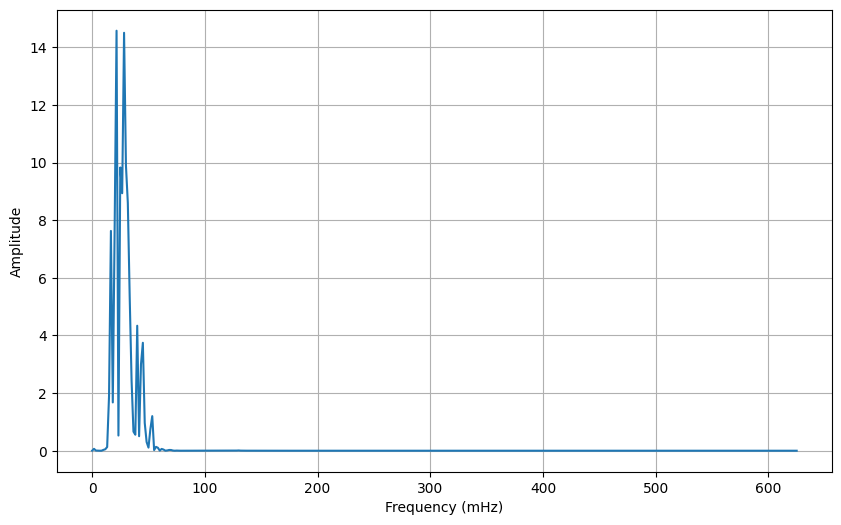

In [105]:
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
signal = denoised_u[1,0]
fs = 1/0.8

freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))
plt.figure(figsize=(10, 6))
plt.plot(freq_hz*1000, u_spectrum)
#plt.title(f"Spectrum of Mode {mode + 1}, omega = {mvmd_data.iloc[id].omega[-1,mode] * 1000} mHz")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

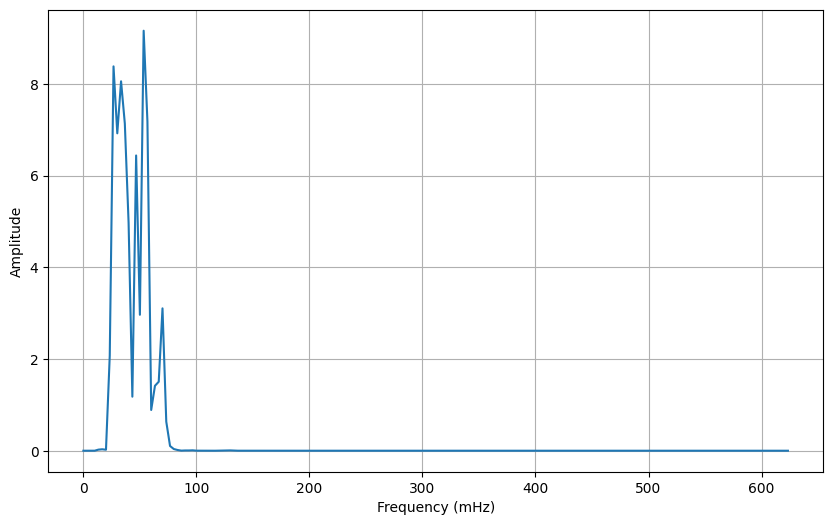

In [106]:
from scipy.signal import periodogram, find_peaks, peak_widths, get_window
signal = mvmd_data.iloc[id].u[1,0]
fs = 1/mvmd_data.iloc[id].sample_rate

freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))
plt.figure(figsize=(10, 6))
plt.plot(freq_hz*1000, u_spectrum)
#plt.title(f"Spectrum of Mode {mode + 1}, omega = {mvmd_data.iloc[id].omega[-1,mode] * 1000} mHz")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [51]:
mvmd_data

,participant,filepath,num_timepoints,u,u_hat,omega,sample_rate,run
0,sub-53888,Run2304/Results_0mean/Results_run-0_2000ms_/K_...,300,"[[[-0.7043285817359699, -0.6733199847696466, -...","[[[(-1.2422012748256976e-11+0j), (-2.675327063...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.005455527087538...",2.0,0
1,sub-55729,Run2304/Results_0mean/Results_run-0_2000ms_/K_...,300,"[[[-4.205365702424093, -4.088715319897228, -3....","[[[(7.0982929990039875e-12+0j), (-1.6421627983...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.005455527087538...",2.0,0
2,sub-55746,Run2304/Results_0mean/Results_run-0_2000ms_/K_...,300,"[[[0.17290278000322284, 0.2582502557220848, 0....","[[[(-5.32371974925299e-12+0j), (-1.38002981280...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.005455527087538...",2.0,0
3,sub-55772,Run2304/Results_0mean/Results_run-0_2000ms_/K_...,300,"[[[1.100659032097873, 1.1393619909349528, 1.19...","[[[(3.5491464995019937e-12+0j), (0.88124218358...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.005455527087538...",2.0,0
4,sub-55965,Run2304/Results_0mean/Results_run-0_2000ms_/K_...,300,"[[[1.705467106245718, 1.693050454991363, 1.698...","[[[(-7.985579623879485e-12+0j), (1.19469674519...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.005455527087538...",2.0,0
...,...,...,...,...,...,...,...,...
123,sub-56114,Run2304/Results_0mean/Results_run-4_2000ms_/K_...,300,"[[[-3.037574977800147, -2.9972802454985925, -2...","[[[(2.0884119247930224e-11+0j), (-7.7816036370...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.003955318283020...",2.0,4
124,sub-56118,Run2304/Results_0mean/Results_run-4_2000ms_/K_...,300,"[[[-0.5378247239787871, -0.4552558287796238, -...","[[[(-2.996417109485641e-11+0j), (-1.8752470530...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.003955318283020...",2.0,4
125,sub-56122,Run2304/Results_0mean/Results_run-4_2000ms_/K_...,300,"[[[1.2239309930771216, 1.1984395666921455, 1.1...","[[[(4.540025923463093e-12+0j), (0.072138172292...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.003955318283020...",2.0,4
126,sub-56141,Run2304/Results_0mean/Results_run-4_2000ms_/K_...,300,"[[[0.834432377072772, 0.867986790762541, 0.844...","[[[(1.5436088139774512e-11+0j), (3.56497875931...","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.003955318283020...",2.0,4


In [ ]:
def find_dominant_frequency(signal, fs=1, bandwidth=False):
    """
    Find the dominant frequency of a temporal signal and the peak bandwidth
    
    Parameters:
        signal (array_like): The input temporal signal.
        sampling frequency or sampling rate(float): The sampling rate of the signal.
    
    Returns:
        dominant_frequency (float): The dominant frequency of the signal.
    """

    freq_hz, u_spectrum = periodogram(signal, fs=fs,
                                           scaling='spectrum',                                        detrend=False,
                                           window=get_window('hamming', Nx=len(signal)))

    # Smooth spectorgarm
    u_spectrum = convolve_with_gaussian(signal=u_spectrum, sigma=3)

    # Extend expectrum to avoid problems at zero
    u_spectrum = np.insert(u_spectrum, 0, min(u_spectrum))
    ferq_hz = np.insert(freq_hz, 0, -freq_hz[1])

    # Determine the dominant ferquency peak
    peak_list, _ = find_peaks(u_spectrum, prominence=1)

    
    # Check for unclearsolutions
    if len(peak_list) == 0: # No peak found
        peak_list, _ = find_peaks(u_spectrum, prominence=0.5)

        # If no clear peak is found take the central frequency
        if len(peak_list) == 0:
            peak_list = [1]


    # Determine bandwidth
    if bandwidth:
        results_half = peak_widths(u_spectrum, peak_list, rel_height=0.5)

        # Bandwidth
        bandlimit_l = max(0, freq_hz[int(results_half[2][0])])
        bandlimit_r = freq_hz[int(results_half[3][0])]

        # Return the first dominant peak and its bandwidth
        return freq_hz[peak_list][0], [bandlimit_l, bandlimit_r]
    
    else: # Return the first dominant peak
        return freq_hz[peak_list][0]

def convolve_with_gaussian(signal, sigma=1):
    import numpy as np
    from scipy.signal import convolve
    from scipy.signal.windows import gaussian
    
    # Create a Gaussian filter
    gauss_filter = gaussian(int(5 * sigma), sigma)

    # Perform convolution
    convolved_signal = convolve(signal, gauss_filter, mode='same')

    return convolved_signal

In [ ]:
from scipy.signal import periodogram, find_peaks, peak_widths, get_window

print(find_dominant_frequency(signal, fs=fs, bandwidth=True))
print(mvmd_data.iloc[id].omega[-1,0])

(0.02, [0.0033333333333333335, 0.03333333333333333])
0.00889126044816174


In [68]:
mvmd_data.iloc[id].omega[-1, 1]

0.024097692304679286

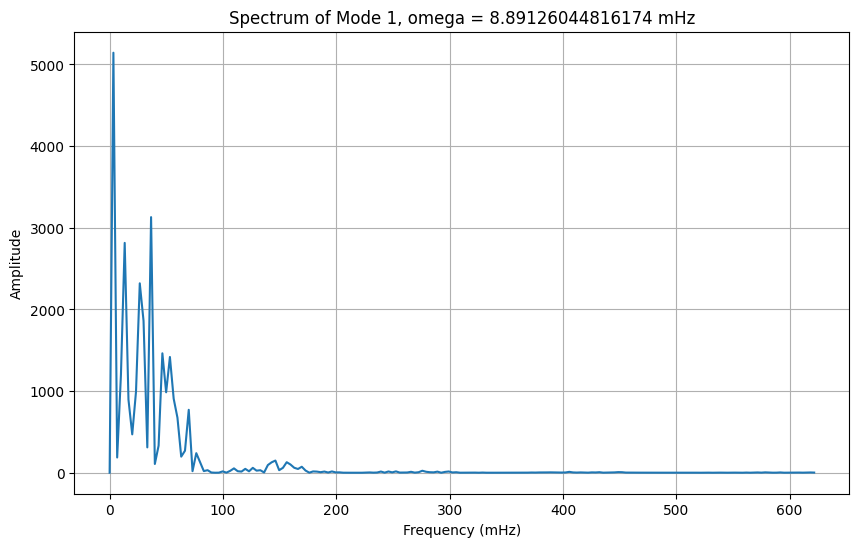

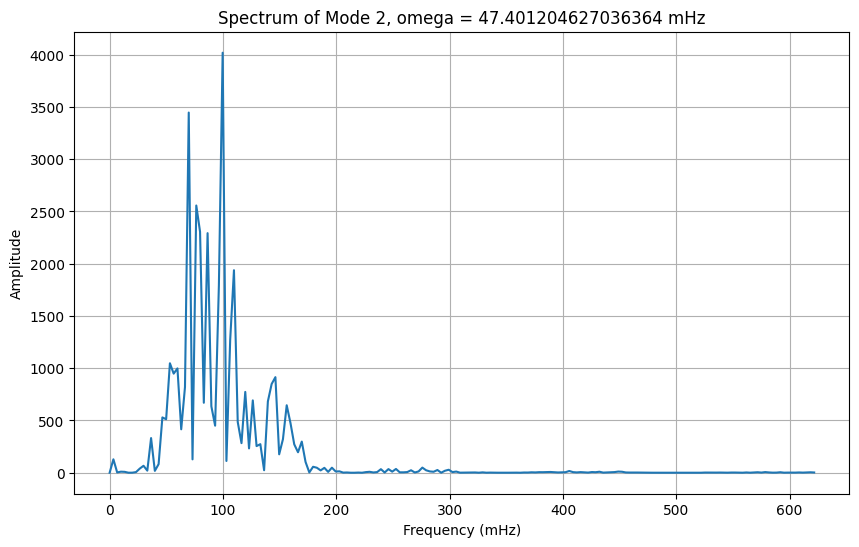

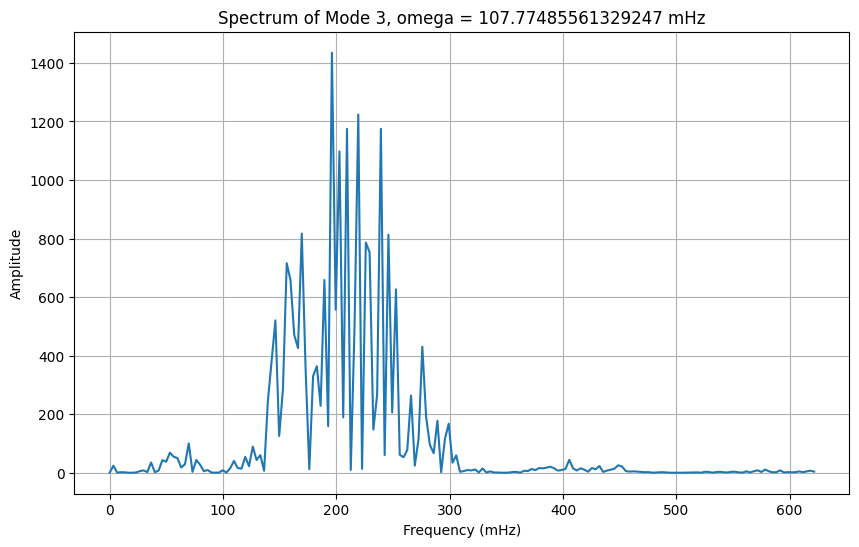

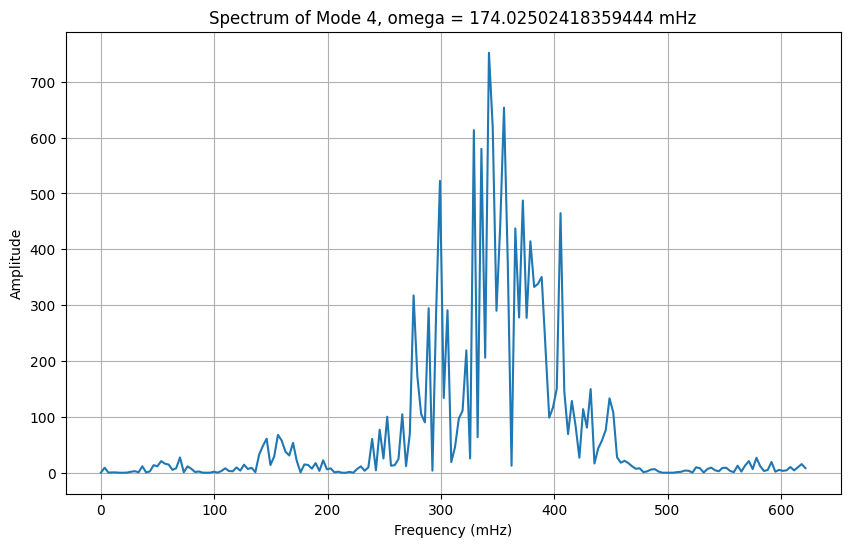

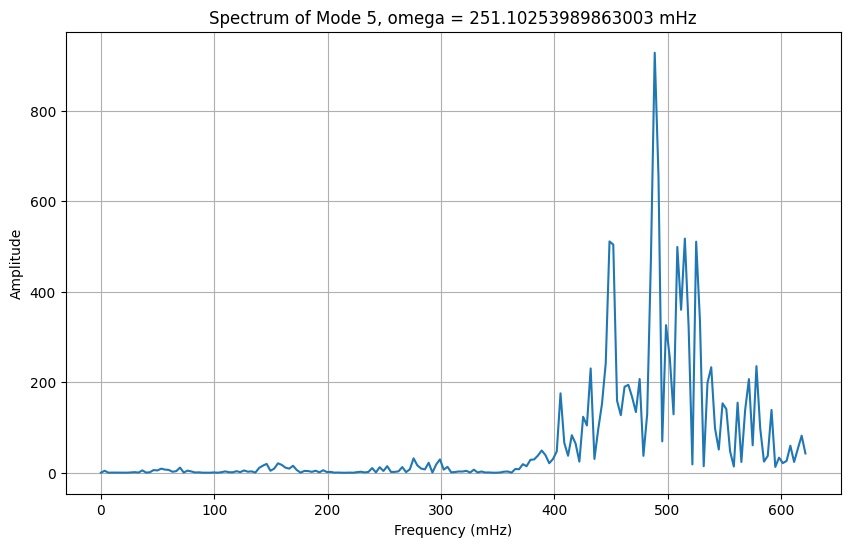

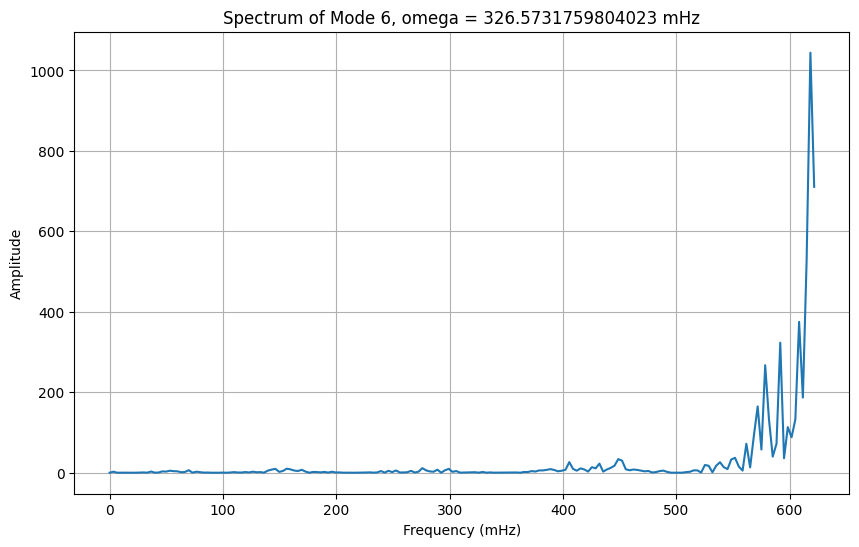

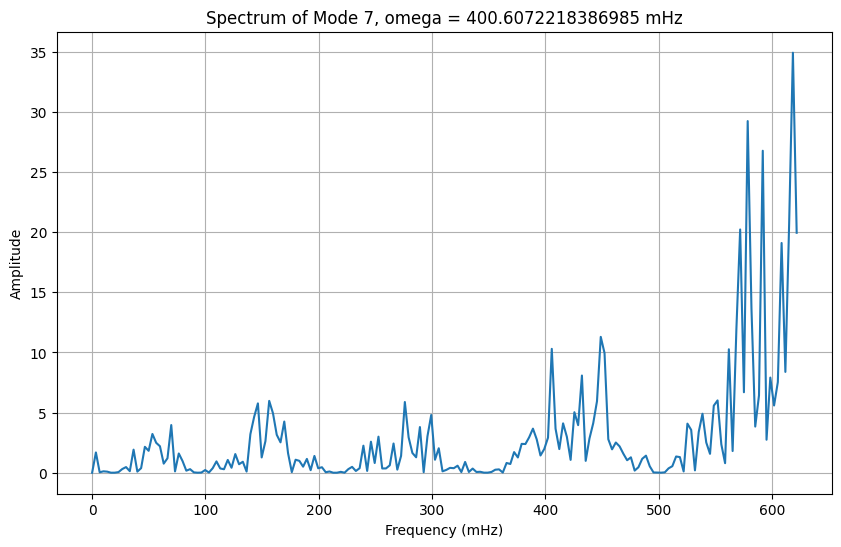

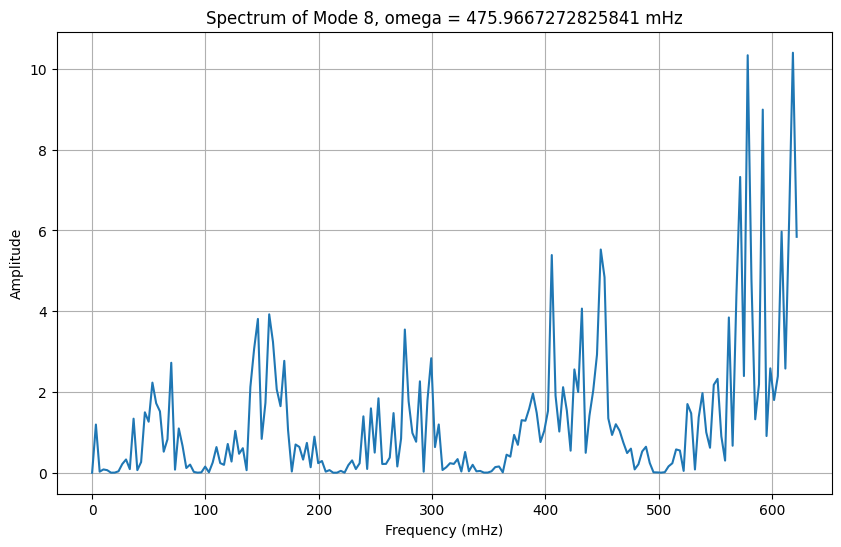

In [75]:
id = 80
fs = 1 / mvmd_data.iloc[id].sample_rate # Replace with the actual sampling rate in Hz

# Loop through the first 3 modes and plot their spectrums
for mode in range(8):
    spectrum = mvmd_data.iloc[id].u_hat[mode, 2]
    frequencies = np.fft.fftfreq(len(spectrum), d=1 / fs) * 1000

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies[:len(frequencies) // 2], np.abs(spectrum[:len(frequencies) // 2]))
    plt.title(f"Spectrum of Mode {mode + 1}, omega = {mvmd_data.iloc[id].omega[-1,mode] * 1000} mHz")
    plt.xlabel("Frequency (mHz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

In [46]:
0.008*1000, 0.09*1000

(8.0, 90.0)

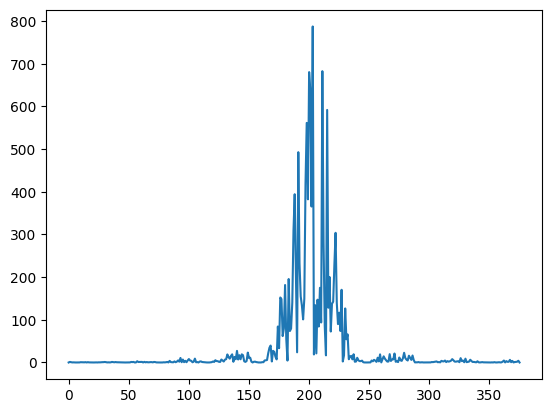

In [ ]:

plt.plot(np.abs(spectrum))